# Lecture 2 - Foundations of Generalized Linear Models: Binary Logistic and Count Regressions

## Loading libraries

In [1]:
source("scripts/support_functions.R")
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(broom))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(qqplotr))
suppressPackageStartupMessages(library(AER))
suppressPackageStartupMessages(library(MASS))
library(performance)
library(see)
library(glmbb)

## 1. Learning Goals

By the end of this lecture, we will be able to:

- Explain the concept of generalized linear models (GLMs).
- Differentiate a GLM from an ordinary linear regression model.
- Build up four fundamental GLMs: binary logistic, Poisson, quasi-Poisson, and negative binomial.
- Perform model selection in GLMs through Analysis of Deviance.

 ## 2. Introduction to Generalized Linear Models (GLMs)
 
 In **Lecture 1**, we learned three strategies for dealing with datasets where the response range is restricted.

Ordinary multiple linear regression models a continuous response $Y_i$ (a random variable) via its mean (or expected value) $\mu_i$ subject to $p$ regressors $X_{i,j}$:

```{math}
\begin{gather*}
\mu_i = \mathbb{E}(Y_i \mid X_{i,1}, \ldots, X_{i,p}) = \beta_0 + \beta_1 X_{i,1} + \ldots + \beta_p X_{i,p} \\ \; \; \; \; \text{since} \; \; \; \; \mathbb{E}(\varepsilon_i) = 0.
\end{gather*}
```

But $Y_i$ could be have a different nature, e.g., a discrete count or scale. Hence, we rely on a monotonic and differentiable function $h(\mu_i)$ called the **link function** for the mean $\mu_i$ of the random variable $Y_i$.

> **Heads-up:** $h(\mu_i)$ is the key for GLMs.

> **Important:** The link function $h(\mu_i)$ is a crucial element in a GLM since it allows us to establish the functional relationship between the response and the regressor in this class of linear model. Note that the form of this link function will also change how we will interpret our estimated regression coefficients $\hat{\beta}_j$.

A GLM has the components of the conceptual regression model in a random sample of $n$ elements as:

1. **Random component.** Each *response* $Y_1,\ldots,Y_n$ is a random variable with its respective mean $\mu_i$.

2. **Systematic Component.** How the $p$ regressors come into the model denoted by the link function $h(\mu_i)$ on the left-hand side:

$$
h(\mu_i) = \beta_0 + \beta_1 X_{i,1} + \beta_2 X_{i,2} + \ldots + \beta_p X_{i,p} \; \; \; \; \text{for} \; i = 1, \ldots, n.
$$

> **Heads-up:** The model in the equation above does not have an explicit **random component** as in the *ordinary linear regression* model with a continuous response. The randomness is expressed directly in the response $Y_i$.

3. **Link function.** The element that connects the **random component** with the **systematic component**. The connection is made through $h(\mu_i)$:

$$
h(\mu_i) = \beta_0 + \beta_1 X_{i,1} + \beta_2 X_{i,2} + \ldots + \beta_p X_{i,p}.
$$

## 3. Binary Logistic Regression


### 3.1. The Breast Cancer Dataset

The data frame `breast_cancer` is the Wisconsin Diagnostic Breast Cancer dataset ([Mangasarian et al., 1995](http://ubc.summon.serialssolutions.com/2.0.0/link/0/eLvHCXMwlV1Nb9QwEB2xPSA4tHQLohRKDoDgsDSJndiRKlApVBx74PNk2bGDKui2jbf8Ff4uM46tbpZKFZdIO55NvNLLeLx-8waAla_z2UpMEAZXtlZKzllZGSk7WTBdtDa3ts6N61aoOnUqjSGWZaAJhkN9zJfML7dHCi-yfnt-MaPmUXTIGjtpTGAi2cDr-rKkvFsPbQwYBpyafxsvQMTDbPEOVxE5yQSH8iZKHH2iKv4TrsMadLQBKk03kU9WagPHAo___7vuwXpMT7ODAU-bcMvNp3A7seOnsJG6QGQxKEzh7pKk4RQ2o91nL6Oi9ast-LN_qvufb94RAX6xvxc-ZIPtkFDXj23vB_rfiR-b9dxmx_3ZdUO_T_TYgFtsfIXHtuOBinaK84wD9-Hz0YdPhx9nsSPEDPeBJWmp6pJ3VS1tzlvR8Ua6WljWlm3RaMkMs52R1jmJWGu4a6wwtugaaauGtQWaH8Da_GzuHkJWVlpwbgpthKOz3aZsmeRWC9mJxnG7DS8STNT5IPyhaMOEO0xF_WkUZ4qrSuTomEB0k-MzgpiK3UXx4un_F_9DX3qvDjCPw2yPMbxfcCPwLXrd6lgngdMmqa5lx6cJqyoiNTzQLz3xeRq4YWZbAYxXXgGJ27CT8K5iZPOqJEFAUnl8dP2XduDOUPVPjObHsLboL92TIGmxCxPx9TteMcDshnf0L2aRR50)). It has a **binary** response `target`: whether the tumour is `benign` or `malignant`.

> The data frame `breast_cancer` contains 569 observations from a digitized image of a fine needle aspirate (FNA) of a breast mass. The dataset details 30 real-valued characteristics (i.e., continuous regressors) plus the binary response and ID number. We will start working with the response `target` subject to the regressor `mean_radius`.

In [2]:
breast_cancer <- suppressWarnings(suppressMessages(read_csv("datasets/breast_cancer.csv")))

breast_cancer_binary <- breast_cancer %>%
  dplyr::select(mean_radius, target)
head(breast_cancer_binary)

mean_radius,target
<dbl>,<chr>
17.99,malignant
20.57,malignant
19.69,malignant
11.42,malignant
20.29,malignant
12.45,malignant


We have to set our binary response $Y_i$ mathematically as:

$$
Y_i =
\begin{cases}
1 \; \; \; \; \mbox{if the $i$th tumour is malignant},\\
0 \; \; \; \; 	\mbox{otherwise.}
\end{cases}
$$

The "1" category is referred as *success*. Note each $Y_i$ is a Bernoulli trial whose probability of success is $\pi_i$, i.e., $Y_i \sim \text{Bernoulli}(\pi_i)$.

Suppose we use the "1" and "0" in the response as probabilities and we estimate an ordinary least squares (OLS) regression model to predict the mean of $Y_i$ subject to `mean_radius`, $X_{\texttt{mr}_i}$: 

$$
\mathbb{E}(Y_i \mid X_{\texttt{mr}_i}) = \pi_i = \beta_0 + \beta_1 X_{\texttt{mr}_i}
$$

In [3]:
breast_cancer_binary <- breast_cancer_binary %>% 
  mutate(target = if_else(target == "malignant", 1, 0))

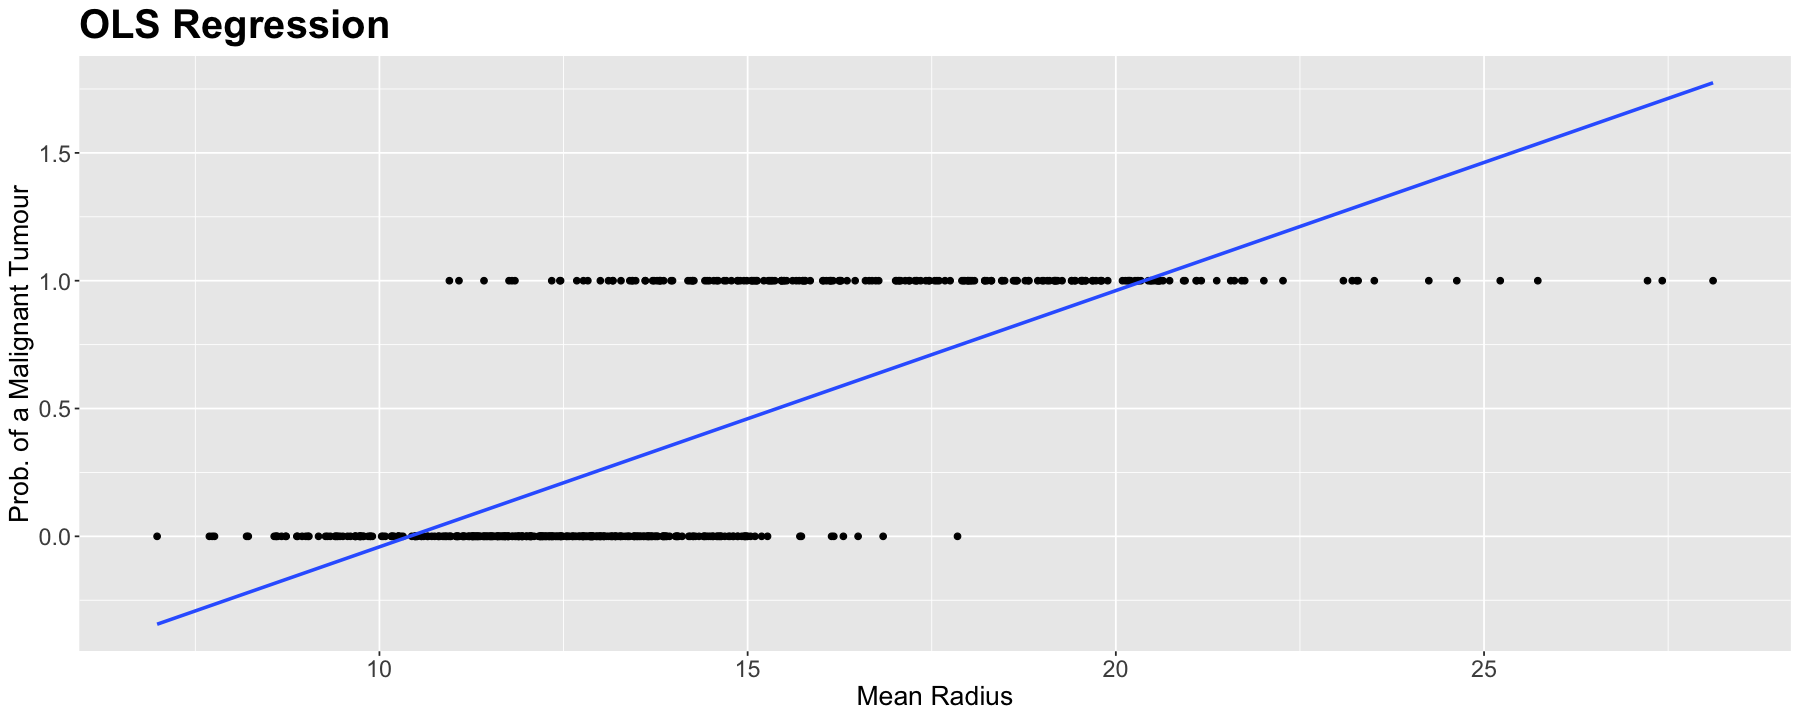

In [4]:
options(repr.plot.height = 6, repr.plot.width = 15)
suppressMessages(print(breast_cancer_binary %>%
  ggplot() +
  geom_point(aes(mean_radius, target)) + geom_smooth(aes(mean_radius, target), method = "lm", se = FALSE) +
  labs(y = "Prob. of a Malignant Tumour", x = "Mean Radius") + ggtitle("OLS Regression") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 16)
  ))) 

The code above transforms the response `target`, via `mutate()`, as a probability with two possible outcomes: $1$ for `malignant` and $0$ for `benign`. Thus the plot shows two subsets of points located on two horizontal lines. The fitted values of the OLS regression model of the 569 observations, with `mean_radius` as a regressor, are shown on the blue line. Recall that a probability cannot be negative or larger than $1$. Nonetheless, values larger than $20$ for `mean_radius` generate predictions larger than $1$, which is absurd for a probability. Moreover, small values of `mean_radius` generate predictions of less than $0$, which again does not make sense.

Is there a way to overcome this issue?

A logarithmic transformation will not save the day here, since we have $Y_i$ values equal to zero.

Since $\mathbb{E}(Y_i) = \pi_i$, we could rely on a link function as follows:

$$
h(\pi_i) = \mbox{logit}(\pi_i)= \log\left(\frac{\pi_i}{1 - \pi_i}\right) = \beta_0 + \beta_1 X_{\texttt{mr}_i}.
$$

The link function $h(\pi_i)$ is called the *logarithm of the odds*, or *logit function*. This logit function $\log\left(\frac{\pi_i}{1 - \pi_i}\right)$ covers the entire real line.

How can we transform back $h(\pi_i)$ to the probability $\pi_i$? With some algebraic arrangements, we can come up with the following expression:

$$
\pi_i = \frac{\exp \big( \beta_0 + \beta_1 X_{\texttt{mr}_i} \big) }{ \big[ 1 + \exp \big( \beta_0 + \beta_1 X_{\texttt{mr}_i} \big) \big] } \in [0,1].
$$

Note this modelling framework is called **binary logistic regression**.

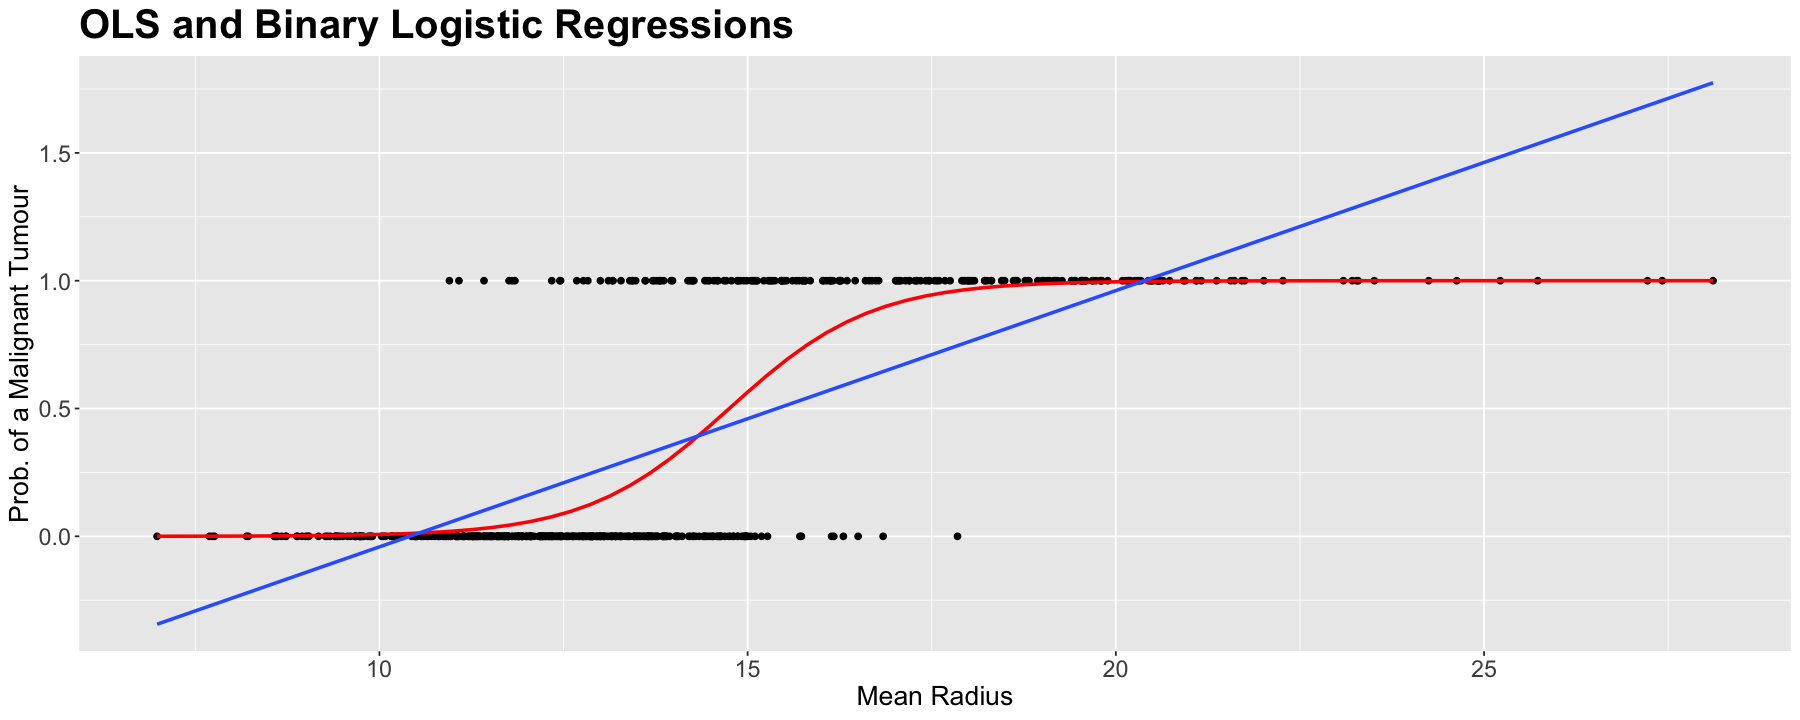

In [5]:
suppressMessages(print(breast_cancer_binary %>%
  ggplot() +
  geom_point(aes(mean_radius, target)) +
  geom_smooth(aes(mean_radius, target), method = "glm", method.args = c(family = binomial), se = FALSE, color = "red") +
  geom_smooth(aes(mean_radius, target), method = "lm", se = FALSE) + labs(y = "Prob. of a Malignant Tumour", x = "Mean Radius") + ggtitle("OLS and Binary Logistic Regressions") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 16)
  )))

The plot above fits this binary logistic regression using `breast_cancer_binary` with `target` as a response and `mean_radius` as a regressor. We can do this via `geom_smooth()` using `method = "glm"` and `method.args = c(family = binomial)`. Then we obtain the **in-sample** predictions $\hat{\pi}_i$ and connect them as a red line. This red $S$-shaped function above is called the *sigmoid function*.

### 3.2. General Modelling Framework of the Binary Logistic Regression

The binary logistic regression model has a response variable in the form:

$$
Y_i =
\begin{cases}
1 \; \; \; \; \mbox{if the $i$th observation is a success},\\
0 \; \; \; \; \mbox{otherwise.}
\end{cases}
$$

As the response variable can only take the values $0$ or $1$, the key parameter becomes the probability that $Y_i$ takes on the value of $1$, i.e. the probability of success, denoted as $\pi_i$. Hence:

$$
Y_i \sim \text{Bernoulli}(\pi_i).
$$

The binary logistic regression approach models the probability of success, $\pi_i$, of the binary response $Y_i$. To re-express $\pi_i$ on an unrestricted scale, the modelling is done in terms of the logit function (the link function in this model). Specifically, $\pi_i$ ($i = 1, 2, \dots, n$) will depend on the values of the $p$ regressors $X_{i, 1}, X_{i, 2}, \dots, X_{i, p}$ in the form:

$$
h(\pi_i) = \mbox{logit}(\pi_i) = \log \bigg( \frac{\pi_i}{1 - \pi_i}\bigg) = \beta_0 + \beta_1 X_{i, 1} + \beta_1 X_{i, 2} + \ldots + \beta_p X_{i, p},
$$

or equivalently

$$
\pi_i = \frac{\exp\big[\mbox{logit}(\pi_i)\big]}{1 + \exp\big[\mbox{logit}(\pi_i)\big]}.
$$

Note that the $\log$ notation in model above refers to the **natural logarithm**, i.e., **logarithm base $e$**. The equation above for $\pi_i$ shows that this binary logistic regression model will result in values of the probability of success $\pi_i$ that are always between 0 and 1. 

The response in this GLM is called the log-odds, the logarithm of the odds $\pi_i/(1 - \pi_i)$, the ratio of the probability of the event to the probability of the non-event. For instance, if the event is that the tumour is malignant, it denotes how likely the $i$th tumour is to be malignant compared to how unlikely it is. Besides, the coefficient $\beta_j$ ($j = 1, \dots, p$) denotes how much the log-odds increases or decreases when the corresponding continuous regressor changes by one unit.

#### 3.2.1. Estimation

The parameters $\beta_0, \beta_1, \dots, \beta_p$ in this model are also unknown. In order to fit the model, we can use the function `glm()` and its argument `family = binomial` (required to specify the binary nature of the response), which obtains the estimates $\hat{\beta}_0, \hat{\beta}_1, \dots \hat{\beta}_p$ (note the hat notation). The estimates are obtained through maximum likelihood where we assume a joint probability mass function of the $n$ responses $Y_i$.

In [6]:
binary_log_model <- glm(as.factor(target) ~ mean_radius,
  data = breast_cancer_binary, family = binomial
)

#### 3.2.2. Inference

We can determine whether a regressor is statistically associated with the logarithm of the odds through hypothesis testing for the parameters $\beta_j$.

We will need information about the estimated regression coefficient $\hat{\beta}_j$ and its corresponding variability which is reflected in the standard error of the estimate, $\mbox{se}(\hat{\beta}_j)$. 

To determine the statistical significance of $\hat{\beta}_j$, you can use the Wald statistic $z_j$

$$
z_j = \frac{\hat{\beta}_j}{\mbox{se}(\hat{\beta}_j)}
$$

to test the hypotheses

$$H_0: \beta_j = 0$$
$$H_a: \beta_j \neq 0.$$

A statistic like $z_j$ is referred to as a $t$-value in OLS regression. However, in binary logistic regression, provided the sample size $n$ is large enough, $z_j$ has an approximately standard normal distribution under $H_0$ rather than a $t$-distribution.

`R` provides the corresponding $p$-value for each $\beta_j$. The smaller the $p$-value, the stronger the evidence against the null hypothesis $H_0$. Hence, a smalll enough $p$-value (less than the significance level $\alpha$) indicates that the data provides evidence in favour of association between the log-dds and the $j$th regressor. Furthermore, given a specified level of confidence, we can construct approximate $(1 - \alpha) \times 100\%$ confidence intervals for the corresponding true value of $\beta_j$:

$$
\hat{\beta}_j \pm z_{\alpha/2}\mbox{se}(\hat{\beta}_j),
$$

where $z_{\alpha/2}$ is the upper $\alpha/2$ quantile of the standard normal distribution.

Now, we can answer the folllowing: *is `mean_radius` statistically associated to the logarithm of the odds of `target`?*

In [7]:
tidy(binary_log_model) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-15.246,1.325,-11.510,0
mean_radius,1.034,0.093,11.101,0


Our sample gives us evidence to reject $H_0$ ($p\text{-value} < .001$). So `mean_radius` is statistically associated to the logarithm of the odds of `target`.

#### 3.2.3. Coefficient Interpretation and Prediction

What is the interpretation of the estimate $\hat{\beta}_1$ for `mean_compactness` on the response `target`? We have to transform back our estimated coefficient $\hat{\beta_1}$ to the original scale of the odds $\frac{\pi_i}{1 - \pi_i}$ with `exp()`.

In [8]:
round(exp(binary_log_model$coefficients), 2)

(Intercept) mean_radius 
       0.00        2.81

The interpretation is: "*for each unit increase in `mean_radius`, the tumour is 2.81 times more likely to be malignant than to be benign*".

This example does not provide interpretations for categorical explanatory variables. As in OLS multiple regression, the model fit will estimate multiple regression coefficients for that categorical explanatory variable, one for each level other than the baseline level. The interpretation of each regression coefficient estimated will depend on which category was specified as the baseline category. Recall the table below from **Lecture 1**, which describes dummy variables for a categorical explanatory variable with $m$ categories, where *Level 1* was specified as the baseline level so all $m-1$ dummy variables are zero for that level. The estimated regression coefficient for *Level 2* represents how much the log-odds increases or decreases compared to the baseline category. The same interpretation applies for the regression coefficients for levels $3, \dots, m$. If we want to interpret these coefficients on the original scale of the odds $\frac{\pi_i}{1 - \pi_i}$, then we apply `exp()` to each one of these estimated coefficients.
    
| **Level** | *x*<sub>i,1</sub> | *x*<sub>i,2</sub> |  …  | *x*<sub>*i,*(*m* − 1)</sub> |
|:---------:|:------------------:|:------------------:|:---:|:--------------------------:|
|     **1**     |         0          |         0          |  ⋯  |             0              |
|     **2**     |         1          |         0          |  ⋯  |             0              |
|     ⋮     |         ⋮          |         ⋮          |  ⋱  |             ⋮              |
|    **m**    |         0          |         0          |  ⋯  |             1              |

Now, let us fit a second model with two regressors: `mean_radius` ($X_{\texttt{mr}_i}$) and `mean_texture` ($X_{\texttt{mt}_i}$) for the $i$th observation:

$$
\eta_i = \mbox{logit}(\pi_i)= \log\left(\frac{\pi_i}{1 - \pi_i}\right) = \beta_0 + \beta_1 X_{\texttt{mr}_i} + \beta_2 X_{\texttt{mt}_i}.
$$

In [9]:
breast_cancer_binary_2 <- breast_cancer %>%
  dplyr::select(mean_radius, mean_texture, target)
breast_cancer_binary_2[1:4, ]

mean_radius,mean_texture,target
<dbl>,<dbl>,<chr>
17.99,10.38,malignant
20.57,17.77,malignant
19.69,21.25,malignant
11.42,20.38,malignant


In [10]:
binary_log_model_2 <- glm(as.factor(target) ~ mean_radius + mean_texture,
  data = breast_cancer_binary_2, family = binomial
)
tidy(binary_log_model_2) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-19.849,1.774,-11.189,0
mean_radius,1.057,0.101,10.417,0
mean_texture,0.218,0.037,5.885,0


Both regressors are statistically significant for the response `target` ($p\text{-values} < .001$).

In [11]:
round(exp(binary_log_model_2$coefficients), 2)

(Intercept)  mean_radius mean_texture 
        0.00         2.88         1.24

The interpretation for `mean_radius` is: "*for each unit increase in `mean_radius`, the tumour is 2.88 times more likely to be malignant than to be benign while holding `mean_texture` constant*."

The interpretation for `mean_texture` is: "*for each unit increase in `mean_texture`, the tumour is 1.24 times more likely to be malignant than to be benign while holding `mean_radius` constant*."

> **Heads-up:** Note that the estimated coefficients for each regressor are standalone. Hence, we have to clarify that each estimate stands while holding the other regressor constant. This same interpretation holds with more than two regressors.

Now, suppose we want to predict the odds of a tumour being malignant to being benign. This tumour has the following values for `mean_radius` and `mean_texture`: $X_{\texttt{mr}} = 16$ and $ X_{\texttt{mt}} = 20$, respectively.

We could use the model `binary_log_model_2` for making such prediction as follows:

```{math}
\begin{gather*} 
\log \bigg( \frac{\hat{\pi}}{1 - \hat{\pi}}\bigg) = \underbrace{-19.849}_{\hat{\beta}_0} + \underbrace{1.057}_{\hat{\beta}_1}(16) + \underbrace{0.218}_{\hat{\beta}_2}(20) = 1.43 \\
\frac{\hat{\pi}}{1 - \hat{\pi}} = 4.17.
\end{gather*}
```

In [12]:
round(exp(predict(binary_log_model_2,
  tibble(mean_radius = 16, mean_texture = 20),
  type = "link"
)), 2)

1 
4.17

Hence, a tumour with $X_{\texttt{mr}} = 16$ and $ X_{\texttt{mt}} = 20$ is predicted to be 4.17 times more likely to be malignant than benign.

#### Can We Predict Probabilities For Classification Purposes?

Using the function `predict()` with the object `binary_log_model_2`, we can obtain the estimated probability for a tumour to be malignant with the following values for `mean_radius` and `mean_texture`: $X_{\texttt{mr}} = 16$ and $ X_{\texttt{mt}} = 20$ respectively.

In [13]:
round(predict(binary_log_model_2,
  tibble(mean_radius = 16, mean_texture = 20),
  type = "response"
), 2)

1 
0.81

#### 3.2.4. Model Selection

##### 3.2.4.1. Analysis of Deviance

The deviance ($D_p$) criterion can be used to compare a given model with $p$ regressors with that of a *baseline model*. The usual *baseline model* is the *saturated* or *full* model, which perfectly fits the data because it allows a distinct probability of *success* $\pi_i$, unrelated to the $p$ regressors.

The maximized likelihood of this full model is denoted as $\hat{\mathscr{l}}_f$. Now, let $\hat{\mathscr{l}}_p$ be the value of the maximized likelihood computed from our dataset of $n$ observation with $p$ regressors.

We can compare the fits provided by these two models by the deviance $D_p$ given by

$$
D_p = -2 \log \Bigg(\frac{\hat{\mathscr{l}}_p}{\hat{\mathscr{l}}_f} \Bigg) =  -2 \big(\log\hat{\mathscr{l}}_p - \log\hat{\mathscr{l}}_f \big).
$$

Note that $D_p$ expresses how much our given model deviates from the full model on log-likelihood scale. This metric is interpreted as follows:

- Large values of $D_p$ arise when $\hat{\mathscr{l}}_p$ is small relative to $\hat{\mathscr{l}}_f$, indicating that our given model fits the data poorly compared to the baseline model.
- Small values of $D_p$ arise when $\hat{\mathscr{l}}_p$ is similar to $\hat{\mathscr{l}}_f$, indicating that our given model provides a good fit to the data compared to the baseline model.

We can use the analysis of deviance to perform model selection between two models where one is nested in the other.

For the specific case of the binary logistic regression, it can be shown that $D_p$ is represented by the following equation:

$$
D_p = -2 \sum_{i = 1}^n \big[\hat{\pi}_i \text{logit}(\hat{\pi}_i) + \log (1 - \hat{\pi}_i) \big],
$$

where $\hat{\pi}_i$ is the estimated probability of success for the $i$th observation for $i = 1, \dots, n$ in our random sample **with our fitted model of $p$ regressors**. The equation above comes from maximum likelihood estimation.

> **Note:** The mathematical proof for the previous equation can be checked in [Collett (2003)](https://www-taylorfrancis-com.ezproxy.library.ubc.ca/chapters/models-binary-binomial-data-david-collett/10.1201/b16654-6?context=ubx&refId=fa9f451b-9961-4928-99be-036c68551115) in Chapter 3 (Section 3.8.2). **This is optional material**.

We will use our two models: `binary_log_model` with `mean_radius` as regressor, which is nested in `binary_log_model_2` with `mean_radius` and `mean_texture` as regressors.

The hypotheses are:

```{math}
\begin{gather*}
H_0: \texttt{binary_log_model} \text{ fits the data better than } \texttt{binary_log_model_2} \\
H_a: \text{otherwise.}
\end{gather*}
```

We will use the function `anova()` in the following way:

In [14]:
round(anova(binary_log_model, 
            binary_log_model_2, test = "Chi"), 4)

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,567,330.0108,NA,NA,NA
2,566,291.1233,1,38.8875,0


We obtain a $p\text{-value} < .001$, column `Pr(>Chi)`, which gives us evidence to reject $H_0$. Hence, we do not have evidence to conclude that `binary_log_model` fits the data better than `binary_log_model_2`. In the context of model selection, adding `mean_texture` provides a better fitted model. Hence, we would choose `binary_log_model_2`

Let $D_2$ be the deviance (column `Resid. Dev`) for `binary_log_model_2` in row 2 and $D_1$ (column `Resid. Dev`) the deviance for `binary_log_model` in row 1. The test statistic $\Delta_D$ for the analysis of deviance is given by:

$$
\Delta_D = D_1 - D_2 \sim \chi^2_{1},
$$

which is chi-squared distributed with $1$ degree of freedom (column `Df`) under $H_0$. The degrees of freedom are the **parameters  of difference  between both models** (this has an impact on the factor-type explanatory variables with more than one dummy variable).

##### 3.2.4.2. Akaike Information Criterion (AIC)

One of the drawbacks of the analysis of deviance is that it only allows to test *nested* binary logistic regression models when they have sparse data (each response is associated with a different set of values in the regressors).

Fortunately, we have alternatives for model selection. The AIC makes possible to compare models that are either nested or not. For a model with $p$ model terms and a deviance $D_p$ is defined as:

$$\mbox{AIC}_p = D_p + 2p.$$

Models with **smaller** values of $\mbox{AIC}_p$ are preferred. $\mbox{AIC}_p$ favours models with small values of $D_p$.

> **Heads-up:** However, $\mbox{AIC}_p$ penalizes for including more regressors in the model. Hence, it discourages overfitting which  is key in model selection. We do not perform hypothesis testing for this criterion, we only select that model with the smallest $\mbox{AIC}_p$.

The function `glance()` shows us the $\mbox{AIC}_p$ by model.

In [15]:
glance(binary_log_model) %>% mutate_if(is.numeric, round, 3)

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
751.44,568,-165.005,334.011,342.699,330.011,567,569


In [16]:
glance(binary_log_model_2) %>% mutate_if(is.numeric, round, 3)

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
751.44,568,-145.562,297.123,310.155,291.123,566,569


Following the results of the `AIC` column, we choose `binary_log_model_2` over `binary_log_model`.

##### 3.2.4.3. Bayesian Information Criterion (BIC)

An alternative to AIC is BIC. The BIC also makes possible to compare models that are either nested or not.

For a model with $p$ regressors, $n$ observations used for fitting, and a deviance $D_p$ is defined as:

$$\mbox{BIC}_p = D_p + p \log n$$

Models with **smaller** values of $\mbox{BIC}_p$ are preferred. $\mbox{BIC}_p$ also favours models with small values of $D_p$.

> **Heads-up:** The differences between AIC and BIC will be more pronounced in datasets with large sample sizes $n$. As the BIC penalty of $p \log n$ will always be larger than the AIC penalty of $2p$ when $n > 7$, BIC tends to select models with fewer regressors than AIC. In practice, AIC and BIC are commonly used for model selection.

Following the results of the `BIC` column above, we also choose `binary_log_model_2` over `binary_log_model` (column `BIC`).

#### 3.2.5. Model Diagnostics

Model diagnostic plots in GLMs are not the same ones from OLS regression and *there is still an open research field for them*.

#### 3.2.5.1. Deviance Residuals

We can obtain more than one class of residual. However, we will concentrate on the **deviance residuals**.

A deviance residual for the $i$th binary observation $y_i$ is defined as:

$$
d_i=
\begin{cases}
\sqrt{-2 \log \hat{\pi}_i} \; \; \; \; \mbox{if $y_i = 1$},\\
-\sqrt{-2 \log (1 - \hat{\pi}_i}) \; \; \; \; \mbox{if $y_i = 0$}.
\end{cases}
$$

where $\hat{\pi}_i$ is the predicted probability of success coming from the model.

In [17]:
glance(binary_log_model_2) %>% mutate_if(is.numeric, round, 3)

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
751.44,568,-145.562,297.123,310.155,291.123,566,569


The sum all the $n$ $d_i$s in the model is the deviance $D_p$ (column `deviance` above via function `glance()`).

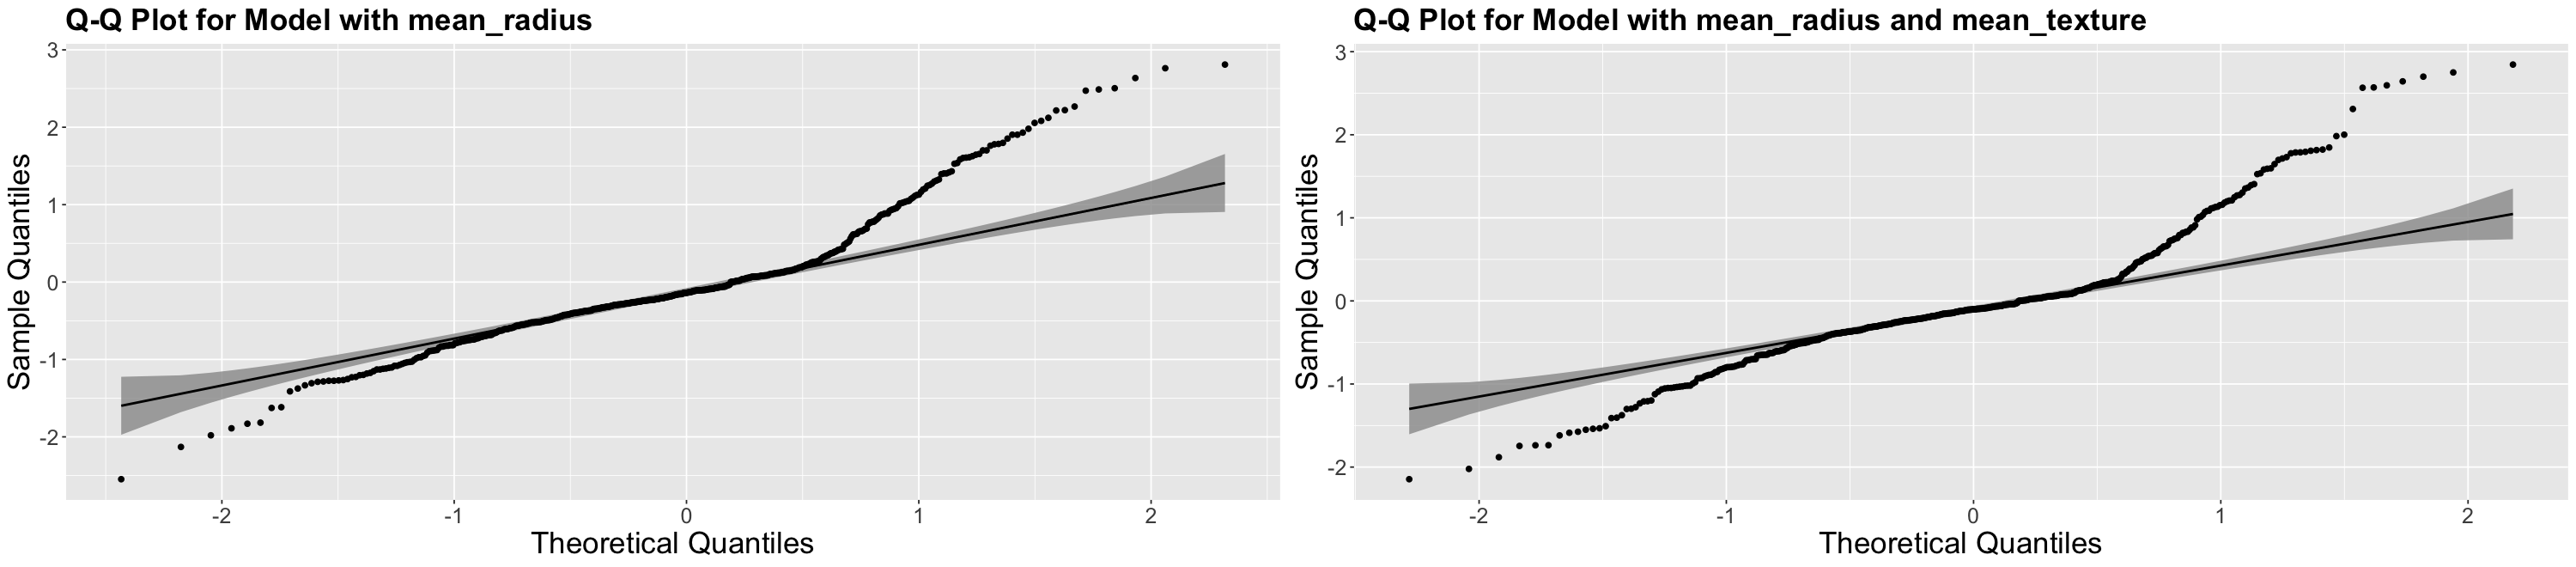

In [18]:
options(repr.plot.height = 5.5, repr.plot.width = 25)
binary_log_model_dev_residuals <- data.frame(dev_residuals = residuals(binary_log_model, type = "deviance"))
binary_log_model_2_dev_residuals <- data.frame(dev_residuals = residuals(binary_log_model_2, type = "deviance"))
plot_grid(
  qqplot_dev_residuals(data = binary_log_model_dev_residuals) +
    ggtitle("Q-Q Plot for Model with mean_radius"),
  qqplot_dev_residuals(data = binary_log_model_2_dev_residuals) +
    ggtitle("Q-Q Plot for Model with mean_radius and mean_texture")
)

With a large enough sample size $n$, the deviance residuals are approximately normally distributed. Hence, we could use $Q$-$Q$ plots for both models. Both plots above are made with package `qqplotr`, based on `ggplot2`. The advantage of `qqplotr` is that, besides the usual 45° degree line, it allows us to plot 95% (by default) *confidence bands*. Since we cannot expect all points to be on the 45° degree line, we still expect them to be within the confidence bands. Nonetheless, we have serious non-normality issues on both models for the most extreme observations.

##### 3.2.5.2. Binned Residual Plots

A plot of the deviance residuals $d_i$ versus fitted values $\mbox{logit}(\pi_i)$ as the one below might not be too informative.

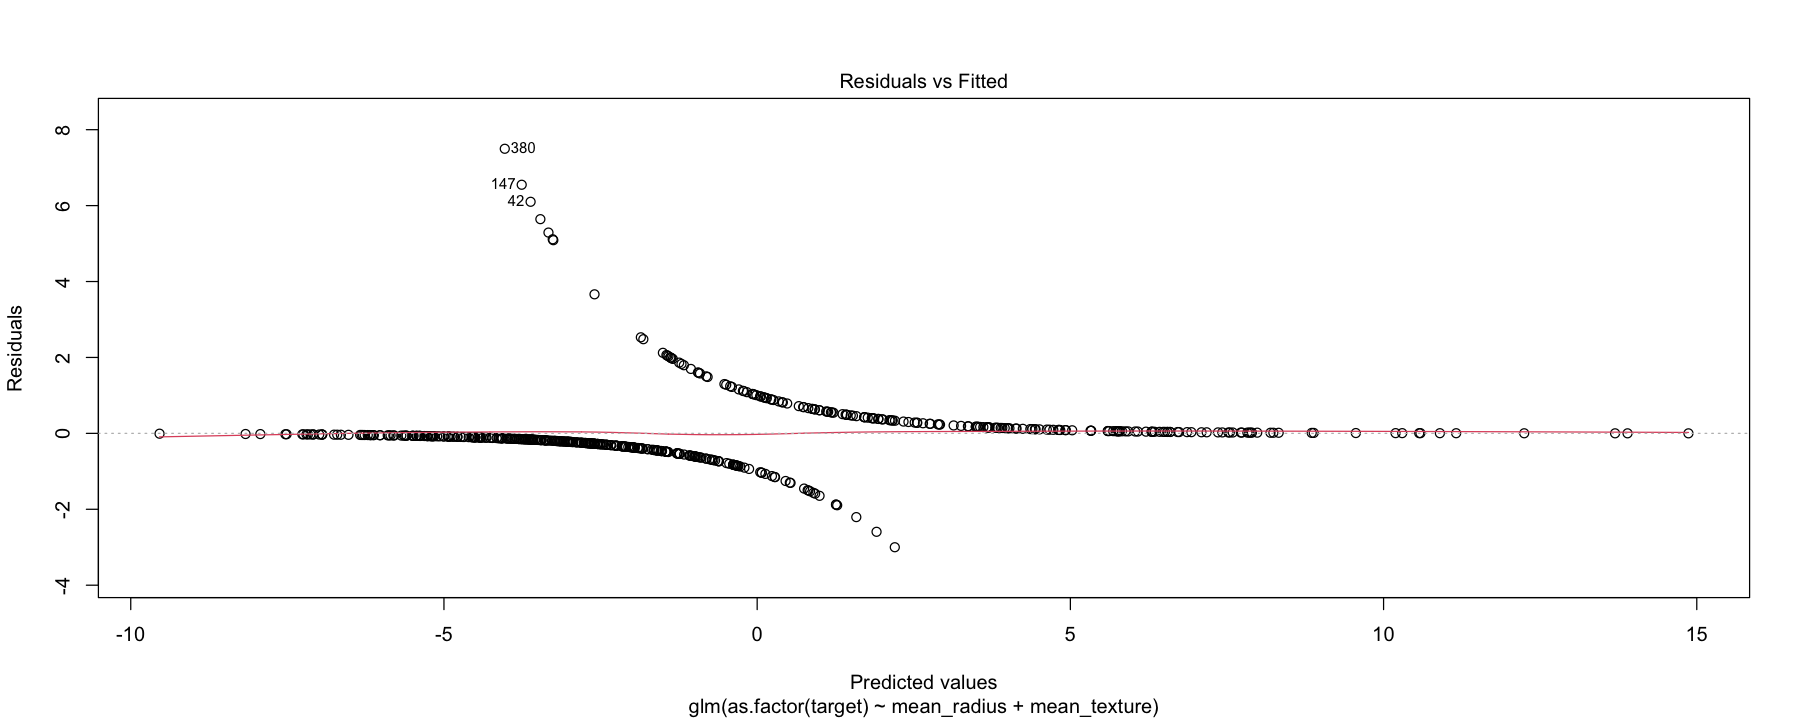

In [19]:
options(repr.plot.height = 6, repr.plot.width = 15)
plot(binary_log_model_2, 1)

The binary logistic regression model obtains the $i$th raw residual $r_i$ as the difference between the binary observed $y_i$ and the fitted value $\hat{\pi}_i$:

$$
r_i = y_i - \hat{\pi}_i \in [0, 1]
$$

[Gelman and Hill (2007)](http://webcat2.library.ubc.ca/vwebv/search?searchArg=Data%20analysis%20using%20regression%20and%20multilevel%2Fhierarchical%20models%20%2F&searchCode=TALL&searchType=1) recommend the use of *binned residual plots*. These plots are available via the package `performance`.

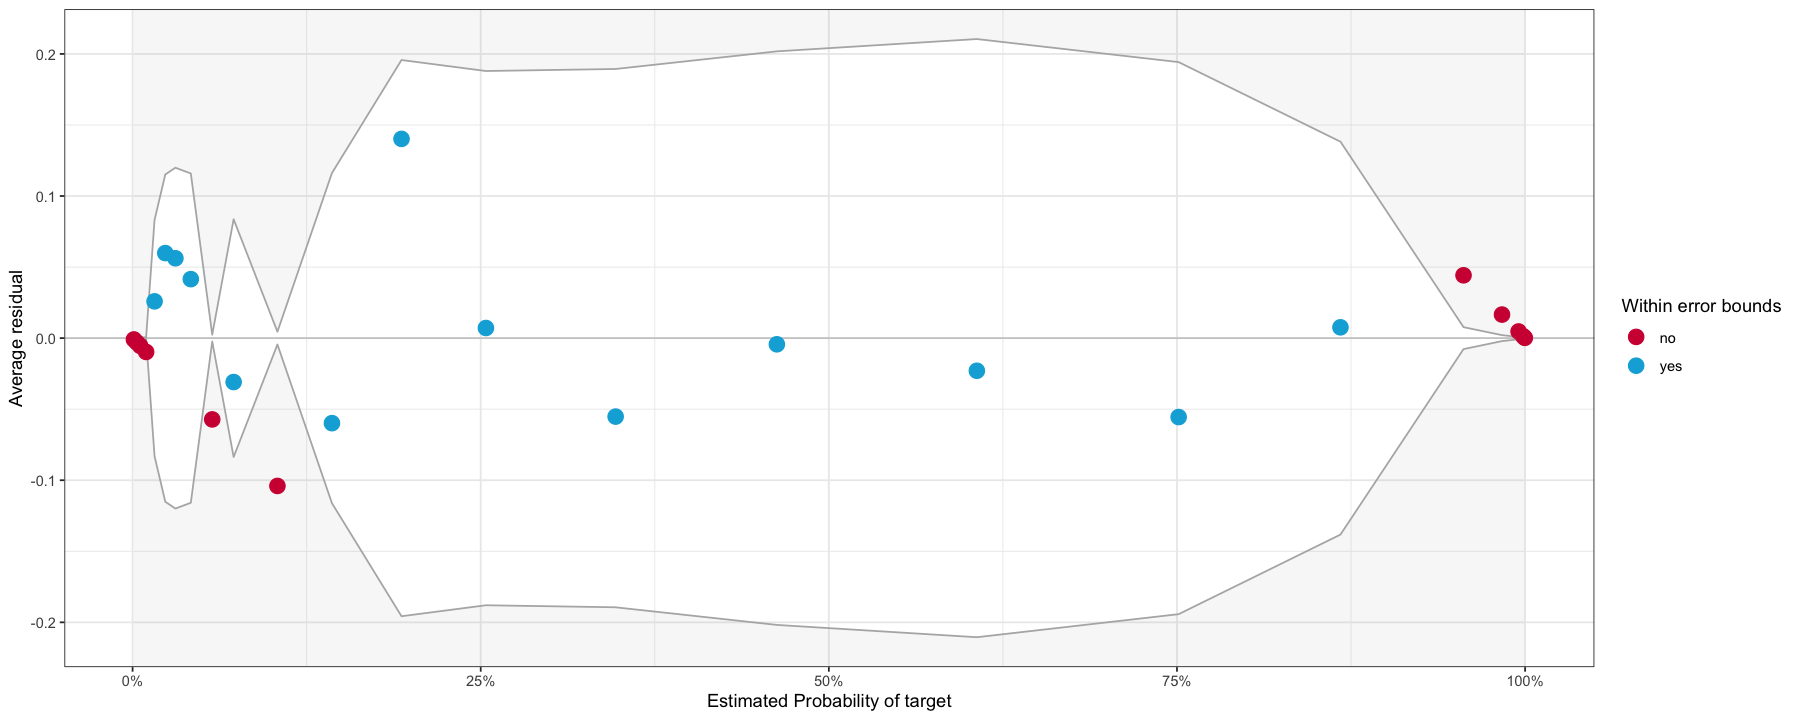

In [20]:
print(binned_residuals(binary_log_model_2, size = 4))

The plot above corresponds to `binary_log_model_2`. The function `binned_residuals()` does the following:

- Unless specified, the default number of bins is $\lceil \sqrt{n} \rceil$ as in the ceiling function: `ceiling(\sqrt(n))`. For the dataset `breast_cancer` we have $n = 569$, leading to 24 bins (i.e. 24 points in the plot).
- The $n$ fitted values $\hat{\pi}_i$ are ordered from smallest to largest.
- The ordered fitted values $\hat{\pi}_1 < \hat{\pi}_2 < \dots < \hat{\pi}_n$ are equally split in the $\lceil \sqrt(n) \rceil$ bins.
- The respective average fitted value per bin is mapped onto the $x$-axis.
- The corresponding average raw residual $\bar{r}$ per bin is mapped on the $y$-axis. 
- Let $\bar{\hat{\pi}}_j$ the average fitted value per bin computed with $n_j$ observations in the $j$th bin. The 95% bounds confidence are computed as $\bar{\hat{\pi}}_j \pm 1.96 \sqrt{\frac{\bar{\hat{\pi}}_j(1 - \bar{\hat{\pi}}_j)}{n_j}},$ where $1.96$ is the $97.5th$ percentile of the standard normal distribution.
- One would expect to have $95\%$ of the points to be within the bounds to have a good model fit.

## 4. Poisson Regression

### 4.1. The Crabs Dataset

The data frame `crabs` ([Brockmann, 1996](https://ubc.summon.serialssolutions.com/2.0.0/link/0/eLvHCXMwrV3JasMwEBUlpZBLl7Sl6YY_oE4sy5sgFEpICKU9NadcjFYSmtghCyRf0t-tJC_EPhRaepMHS8jSSPM0M3oGALkdx67tCYRyKV0GacCp9CBX60RCySMcYiigy2qpOq_F1ZiMLqL0v-mFYrZvvd4JXXcPEnOUZbU1z6W-fxdoh6eO-XQUvDyGCnXrbK_hxCkDDCHKgs9KH20FelDOR_pzWxXbdYhljTEanoF10e8iC6V2SbDK9Pg_H3gOTnPsar1kynYBjkTSAs1yC923wMkkNaVL8NVbkNXn8wcxjJ8b0euaZysTvyuzVJUYH9i6Kpsl1ijVOSbTtPZ2f6V6nYuectnbbLGdb2tNLNP5fjkVi1J-BcbDwbg_svOfQNhMIRdsu4KHEnIsIiQYJoGQvsKQmAuOsE8lojRnrPEIlZQHHIUEEs8PBVHQjaJr0EjSRNwAS8ebmMNk4DHkRYgQSt2ARoxRnzuhJG2AitmNlxnVR3x4REI41sMf6-GP8-GPd20QmVn7RZV4MB7p0u3fq96BZpY-rn1B96CxWW3FgyGOeDR6_g1rIQSN)) is a dataset detailing the **counts** of satellite male crabs residing around a female crab nest: `n_males`.

In [21]:
data(crabs)
crabs <- crabs %>%
  rename(n_males = satell) %>%
  dplyr::select(-y)
head(crabs)

,color,spine,width,n_males,weight
,<fct>,<fct>,<dbl>,<int>,<int>
1,medium,bad,28.3,8,3050
2,dark,bad,22.5,0,1550
3,light,good,26.0,9,2300
4,dark,bad,24.8,0,2100
5,dark,bad,26.0,4,2600
6,medium,bad,23.8,0,2100


> The data frame `crabs` contains 173 observations on horseshoe crabs (Limulus polyphemus). The response is the count of male crabs (`n_males`) around a female breeding nest. It is subject to four explanatory variables: `color` of the prosoma with four levels (nominal factor-type), the condition of the posterior `spine` with three levels (nominal factor-type), the continuous variables carapace `width` (cm), and `weight` (g).

Let us make a scatterplot of `n_males` versus carapace `width` (see below), **even though `n_males` is not continuous**. **Note the characteristic horizontal pattern in the points above since the $y$-axis has repeated counts associated with different `width` values**. This plot pattern paves the way for the use of a Poisson regression model. 

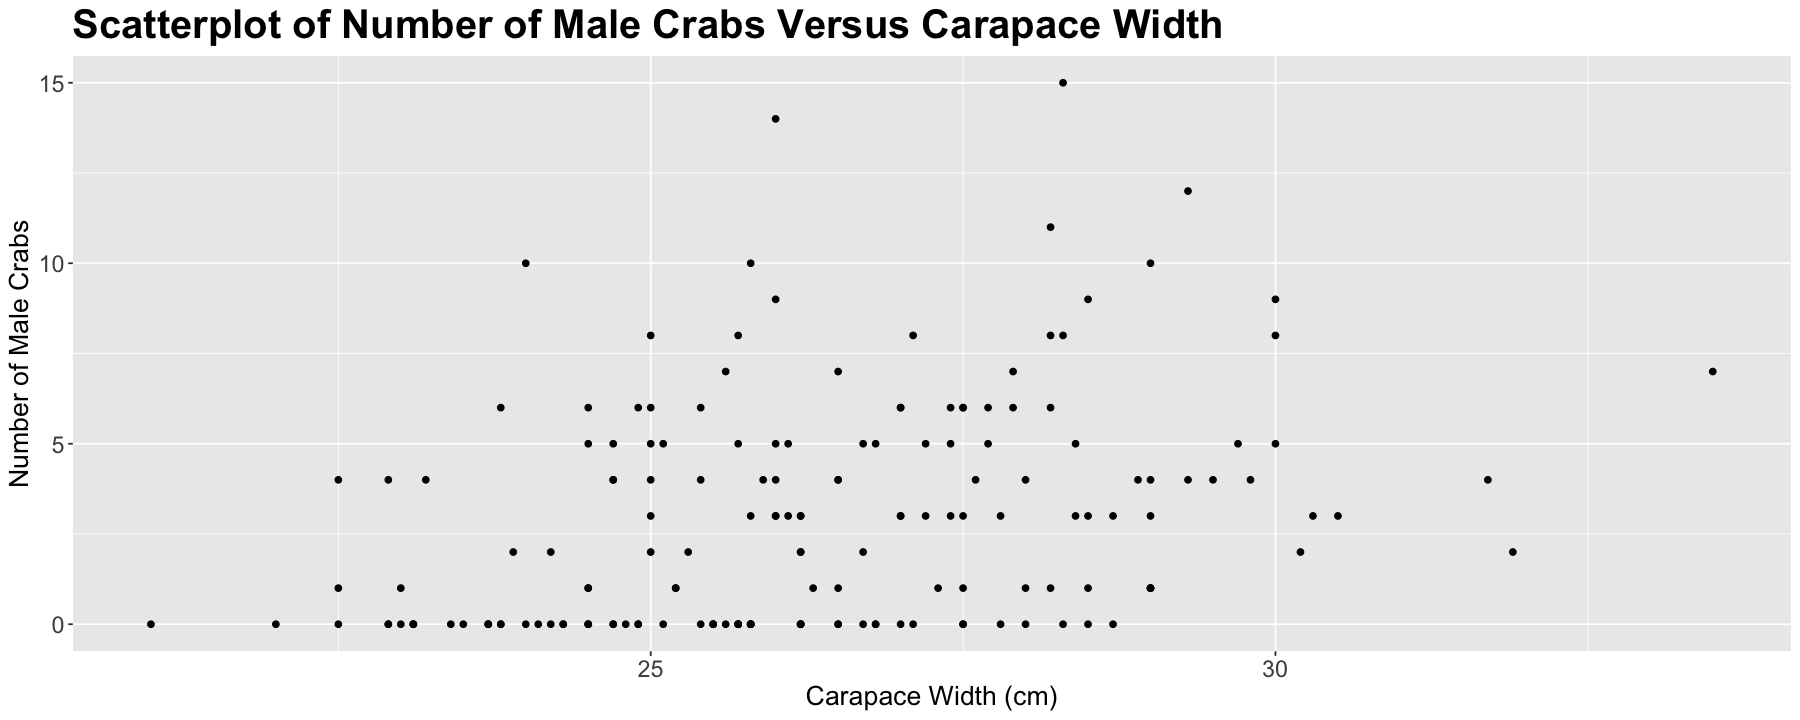

In [22]:
(plot_crabs_vs_width <- crabs %>%
  ggplot() +
  geom_point(aes(width, n_males)) +
  labs(y = "Number of Male Crabs", x = "Carapace Width (cm)") +
  ggtitle("Scatterplot of Number of Male Crabs Versus Carapace Width") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 16)
  ))

Do you think `n_males` increases with the carapace `width`? It is quite difficult to tell with this particular point pattern! 

Since the scatterplot above is too hard to visualize, we could calculate the average `n_males` using a few carapace `width` groups.

In [23]:
group_avg_width <- crabs %>% 
  mutate(intervals = cut(crabs$width, breaks=10)) %>% 
  group_by(intervals) %>% 
  summarise(mean = mean(n_males), n = n()) 
group_avg_width

intervals,mean,n
<fct>,<dbl>,<int>
"(21,22.2]",0.000000,2
"(22.2,23.5]",1.000000,14
"(23.5,24.8]",1.769231,26
"(24.8,26]",2.976744,43
"(26,27.2]",2.531250,32
"(27.2,28.5]",4.151515,33
"(28.5,29.8]",4.000000,13
"(29.8,31]",4.857143,7
"(31,32.2]",3.000000,2


We creater another scatterplot using these `n_males` averages by `width` bins (see below). Now it is easier to visualize and state, descriptively, that there is a positive relationship between carapace `width` and `n_males`. 

> **Heads-up:** Nevertheless, we need to find a suitable regression model to statistically confirm this!

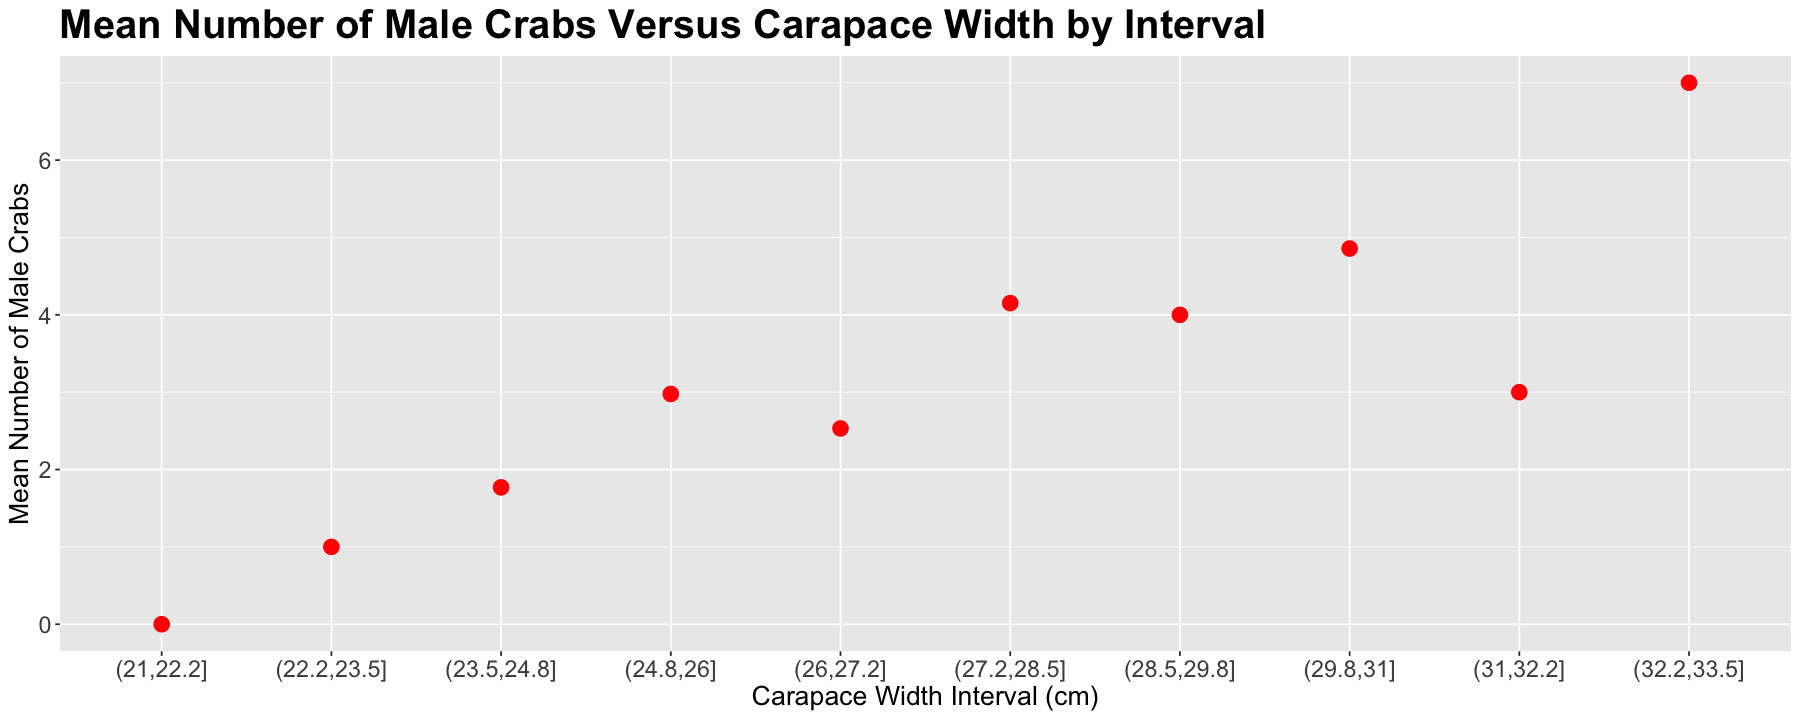

In [24]:
(crabs_avg_width_plot <- group_avg_width %>%
  ggplot() +
  geom_point(aes(intervals, mean), colour = "red", size = 4) +
  labs(y = "Mean Number of Male Crabs", x = "Carapace Width Interval (cm)") +
  ggtitle("Mean Number of Male Crabs Versus Carapace Width by Interval") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 16)
  ))

Given that `n_males` is a count-type response, a more appropriate standalone plot is a bar chart (see below). This bar chart is giving us visual evidence of a possible Poisson random variable, note the skewness.

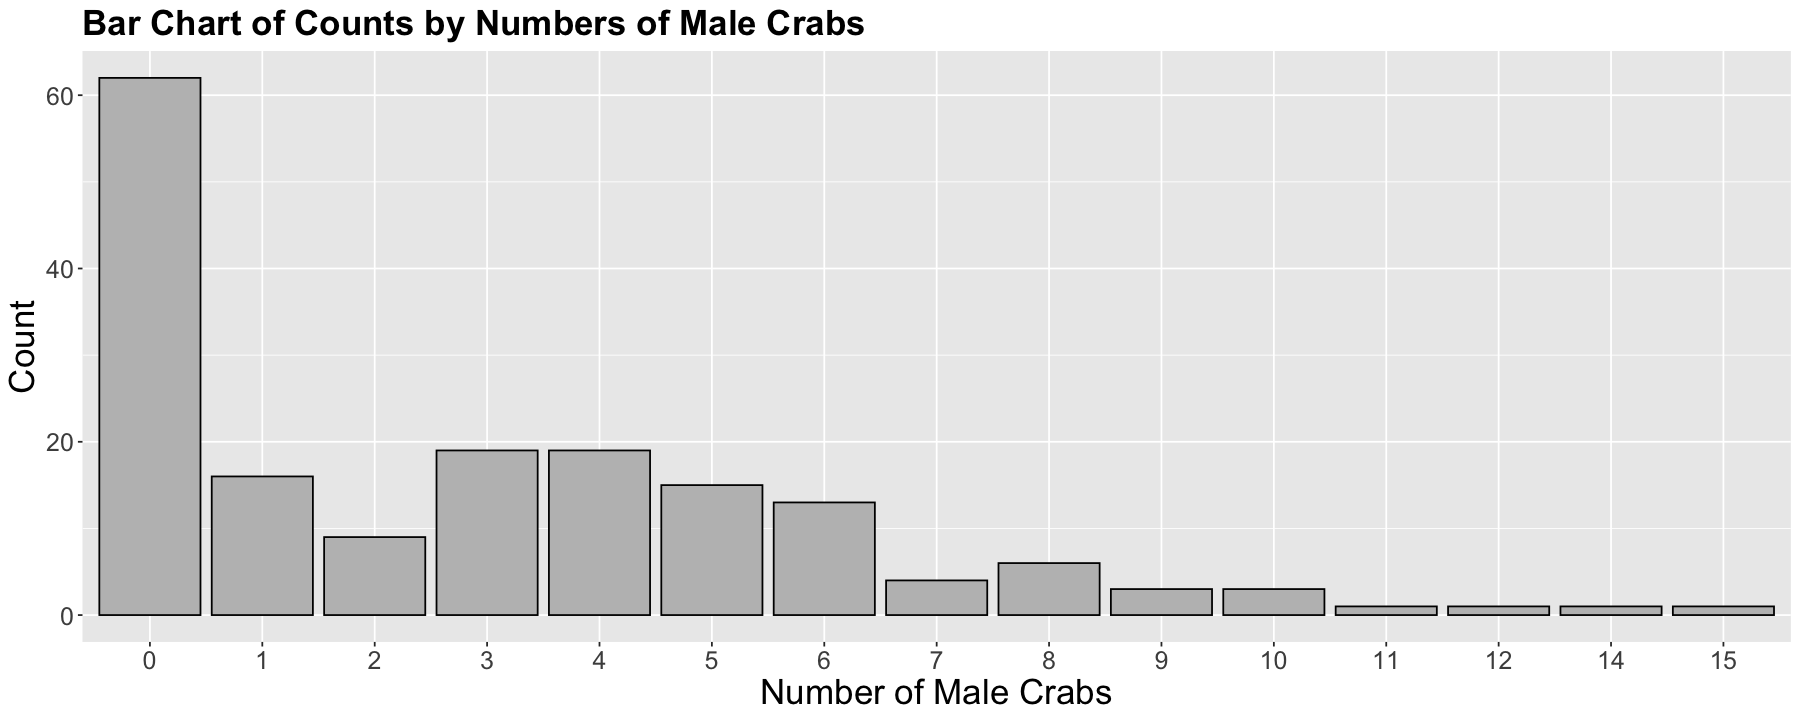

In [25]:
crabs %>%
  ggplot() +
  geom_bar(aes(as.factor(n_males)), fill = "grey", color = "black") +
  theme(
    plot.title = element_text(size = 21, face = "bold"),
    axis.text = element_text(size = 15),
    axis.title = element_text(size = 21),
    legend.text = element_text(size = 21),
    legend.title = element_text(size = 18, face = "bold")
  ) +
  ggtitle("Bar Chart of Counts by Numbers of Male Crabs") +
  labs(x = "Number of Male Crabs", y = "Count")

The distribution of the counts in the response `n_males` is suggesting a possible Poisson distribution. Hence we might use Poisson regression to assess whether carapace `width` is related to `n_males` and quantify the magnitude of the regressor's association (as well as the respective uncertainty associated with its estimation).

### 4.2. General Modelling Framework of the Poisson Regression

Besides OLS and binary logistic regressions, another alternative is a count data model, as in Poisson regression. Unlike the previous regression model, we are using counts as a response variable. Hence, we have to modify the modelling framework to take into account this fact. The Poisson regression model would be the primary resource when it comes to modelling counts. Poisson regression models also fit into the GLM class. Recall that the residual component in the OLS regression model, namely $\varepsilon_i$, is assumed to be normal, making the response $Y_i$ normal. 

Therefore, what is this distributional key difference between a Poisson regression model and the OLS regression model in terms of the response? First of all, we have to specify what a Poisson random variable is. A Poisson random variable refers to discrete data with non-negative integer values that count something. These counts could happen during a given timeframe or even a space such as a geographic unit! A particularity of a Poisson random variable is that its mean is equal to its variance (a particular inconsistency in Dimensional Analysis!). Thus, any factor that affects the mean will also affect the variance. This fact could be a potential drawback for using a Poisson regression model. Nonetheless, an alternative count modelling option could overcome this potential issue, which will be explained further.

The Poisson regression model assumes a random sample of $n$ count observations $Y_i$s, hence independent, which have the following distribution:

$$Y_i \sim \text{Poisson}(\lambda_i)$$

Each $i$th observation has its own $\mathbb{E}(Y_i) = \lambda_i > 0$, which also implicates $\text{Var}(Y_i) = \lambda_i > 0$.

> **Heads-up:** The equality of the expected value and variance in a random variable is called **equidispersion**.

Parameter $\lambda_i$ is the risk of an event occurrence, coming from the definition of the Poisson random variable, in a given timeframe or even a space. 

> **Heads-up:** We have to highlight another particularity in this distribution: **$\lambda_i$ is continuous!**

For our `crabs` dataset the events are the number of male crabs, `n_males`, around a space: *the female breeding nest*.

Suppose we want to make inference on whether the carapace `width` is related to the response `n_males`. Thus, we could use Poisson regression.

Since the Poisson Regression model is also a GLM, we need to set up a link function for the mean: $h(\lambda_i)$.

Let $X_{\texttt{width}_i}$ be the $i$th value for the regressor `width` in our dataset. An easy modelling solution would be an *identity* link function as in 

$$
h(\lambda_i) = \lambda_i = \beta_0 + \beta_1 X_{\texttt{width}_i}.
$$

However, again, we have a response range issue!

The model above for $h(\lambda_i)$ has a significant drawback: the right-hand side is allowed to take on even negative values, which does not align with the nature of the parameter $\lambda_i$ (that always has to be non-negative). Recall the essential characteristic of a GLM that should come into play for a link function. In this class of models, the direct relationship between the original response and the regressors may be non-linear in $h(\lambda_i)$. Hence, instead of using the identity link function $\lambda_i$, we will use the natural logarithm of the mean$: \log(\lambda_i)$.

Before continuing with the `crabs` dataset, let us generalize the Poisson regression model with $p$ regressors as:

$$
h(\lambda_i) = \log(\lambda_i) = \beta_0 + \beta_1 X_{i,1} + \dots + \beta_p X_{i,p}.
$$

In the model depicted above, each one of the $p$ regression coefficients $\beta_{1}, \dots, \beta_{p}$ represents the expected change in the natural logarithm of the mean $\lambda_i$ per unit change in their respective regressors $X_{i,1}, \dots, X_{i,p}$. Nonetheless, we could make more sense in the interpretation by exponentiating the previous equation:

$$
\lambda_i = \exp{(\beta_0 + \beta_1 X_{i,1} + \dots + \beta_p X_{i,p})},
$$

where an increase in one unit in any of the $p$ regressors (while keeping the rest of them constant) multiplies the mean $\lambda_i$ by a factor $\exp{(\beta_j)}$, for all $j = 1, \dots, p$.

In the `crabs` dataset with `width` as a regressor, the Poisson regression model is depicted as:

$$
h(\lambda_i) = \log(\lambda_i) = \beta_0 + \beta_1 X_{\texttt{width}_i}.
$$

As a side note, we have to clarify that the systematic component in the Poisson regression model is explicitly depicted by the regressors and their coefficients as in multiple linear regression. The random component is implicitly contained in each random variable 

$$Y_i \sim \text{Poisson}(\lambda_i).$$

#### 4.2.1. Estimation

The parameters $\beta_0, \beta_1, \dots, \beta_p$ in the model are also unknown. In order to fit the model, we can use the function `glm()` and its argument `family = poisson` (required to specify the Poisson nature of the response), which obtains the estimates $\hat{\beta}_0, \hat{\beta}_1, \dots \hat{\beta}_p$. The estimates are obtained through maximum likelihood where we assume a Poisson joint probability mass function of the $n$ responses $Y_i$.

In [26]:
poisson_model <- glm(n_males ~ width, family = poisson, data = crabs)

#### 4.2.2. Inference

The fitted regression model will also be used to identify the relationship between the response and regressors. We use the Wald statistic and the same hypothesis testing from binary logistic regression.

To determine the statistical significance of $\beta_j$ in this model, we also use the Wald statistic $z_j$:

$$
z_j = \frac{\hat{\beta}_j}{\mbox{se}(\hat{\beta}_j)}
$$

to test the hypotheses

$$H_0: \beta_j = 0$$
$$H_a: \beta_j \neq 0;$$

where the null hypothesis $H_0$ indicates that the $j$th regressor associated to $\beta_j$ does not have any association on the response variable in the model, and the alternative hypothesis $H_a$ otherwise.

The software provides the corresponding $p$-values for each $\beta_j$. The smaller the $p$-value, the stronger the evidence against the null hypothesis $H_0$. As in the previous regression models, we would set a predetermined significance level $\alpha$ to infer if the $p$-value is small enough. If the $p$-value is smaller than the predetermined level $\alpha$, then we could claim that there is evidence to reject the null hypothesis. Hence, $p$-values that are small enough indicate that the data provides evidence in favour of association between the response variable and the $j$th regressor.

Furthermore, given a specified level of confidence where $\alpha$ is the significance level, we can construct approximate $(1 - \alpha) \times 100\%$ confidence intervals for the corresponding true value of $\beta_j$:

$$
\hat{\beta}_j \pm z_{\alpha/2}\mbox{se}(\hat{\beta}_j),
$$

where $z_{\alpha/2}$ is the upper $\alpha/2$ quantile of the standard normal distribution.

In [27]:
tidy(poisson_model) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-3.305,0.542,-6.095,0
width,0.164,0.020,8.216,0


Now, it is time to plot the fitted values coming from `poisson_model` to check whether it provides a positive relationship between carapace `width` and the response `n_males`.

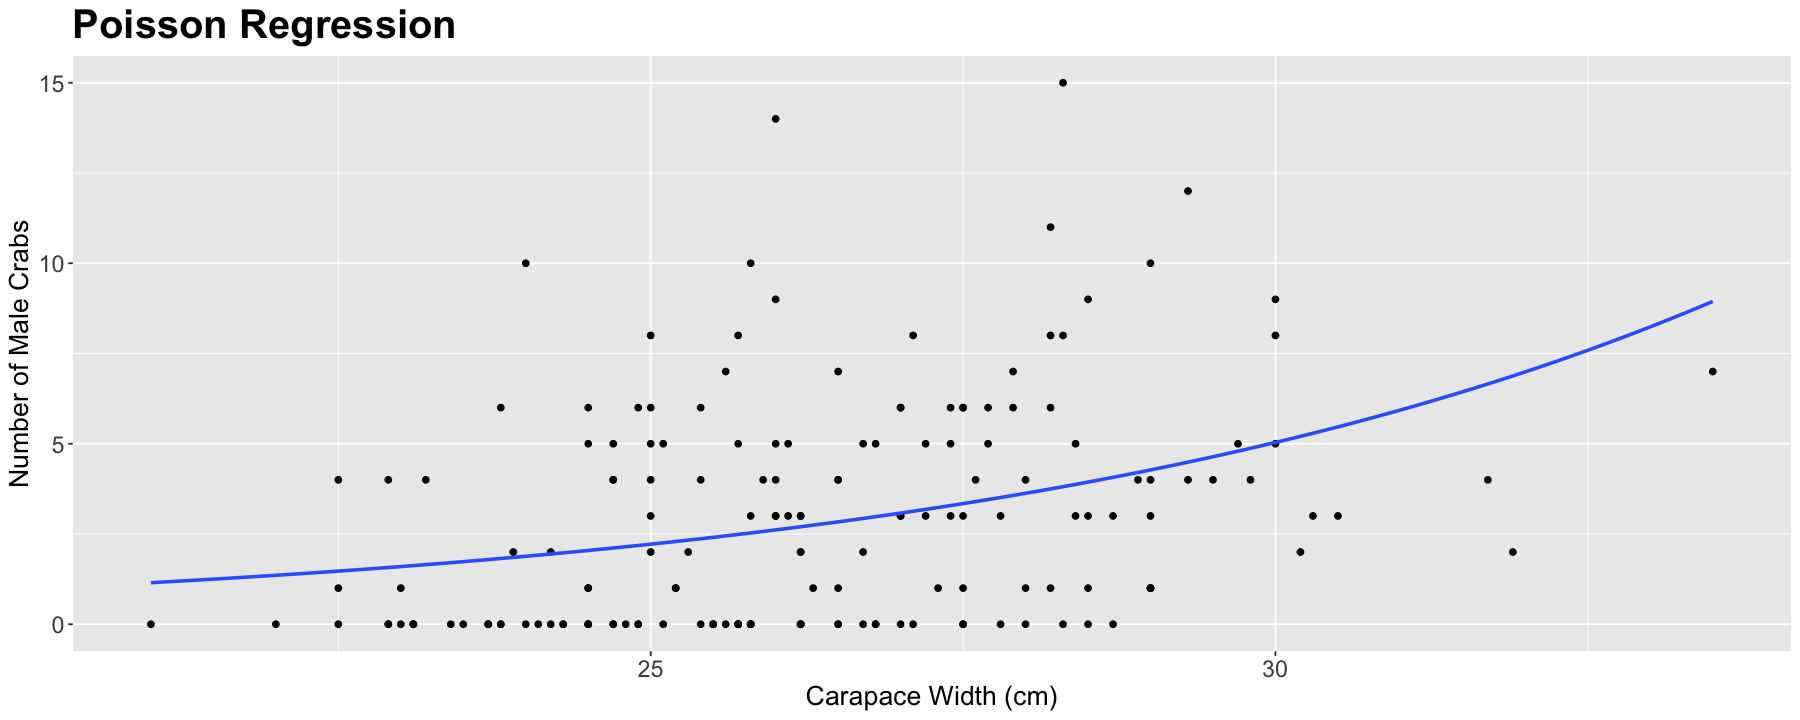

In [28]:
suppressMessages(print(plot_crabs_vs_width <- plot_crabs_vs_width +
  geom_smooth(data = crabs, aes(width, n_males), method = "glm", se = FALSE, method.args = list(family = poisson)) +
  ggtitle("Poisson Regression")))

The blue line in the plot above is the fitted Poisson regression of `n_males` versus carapace `width`. The positive relationship is now clear with this regression line.

#### 4.2.3. Coefficient Interpretation and Prediction

Let us fit a second model with two regressors: `width` ($X_{\texttt{width}_i}$) and `color` ($X_{\texttt{color_darker}_i}$, $X_{\texttt{color_light}_i}$, and $X_{\texttt{color_medium}_i}$) for the $i$th observation:

$$
h(\lambda_i) = \log \lambda_i = \beta_0 + \beta_1 X_{\texttt{width}_i} + \beta_2 X_{\texttt{color_darker}_i} + \beta_3 X_{\texttt{color_light}_i} + \beta_4 X_{\texttt{color_medium}_i}.
$$

The explanatory variable `color` is factor type (discrete) and nominal (its levels do not follow any specific order). Moreover, it has a baseline: `dark`.

In [29]:
levels(crabs$color)

[1] "dark"   "darker" "light"  "medium"

The use of explanatory variables such as `color` involves the use of dummy variables shown in [this table](#table_cat), such as in binary logistic regression. The explanatory variable `color` has four levels, thus this Poisson regression model will incorporate three dummy variables: $X_{\texttt{color_darker}_i}$, $X_{\texttt{color_light}_i}$, and $X_{\texttt{color_medium}_i}$. Depending on the `color`, these dummy variables take on the following values:

- When `color` is `darker`, then $X_{\texttt{color_darker}_i} = 1$ while the other two dummy variables $X_{\texttt{color_light}_i} = X_{\texttt{color_medium}_i} = 0$.
- When `color` is `light`, then $X_{\texttt{light}_i} = 1$ while the other two dummy variables $X_{\texttt{color_darker}_i} = X_{\texttt{color_medium}_i} = 0$.
- When `color` is `medium`, then $X_{\texttt{medium}_i} = 1$ while the other two dummy variables $X_{\texttt{color_darker}_i} = X_{\texttt{color_light}_i} = 0$.

Note that the level `dark` is depicted as the baseline here. Hence, the interpretation of the coefficients in the model for each dummy variable will be with respect to this baseline. We can check what factor level is the baseline using the function `levels()`: the level on the left-hand side (check above).

Now, let us fit this second Poisson regression model:

In [30]:
poisson_model_2 <- glm(n_males ~ width + color, family = poisson, data = crabs)
tidy(poisson_model_2) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-3.086,0.557,-5.536,0.000
width,0.149,0.021,7.166,0.000
colordarker,-0.011,0.180,-0.061,0.951
colorlight,0.436,0.176,2.474,0.013
colormedium,0.237,0.118,2.003,0.045


We can see that `width`, `colorlight`, and `colormedium` are significant according to the `p.value` column (with $\alpha = 0.05$).

First, let us focus on the coefficient corresponding to carapace `width`, *while keeping `color` constant*.

Consider an observation with a given value $X_{\texttt{width}} = \texttt{w}$ cm, and another observation with a given $X_{\texttt{width + 1}} = \texttt{w} + 1$ cm (i.e., an increase of $1$ cm). Then we have their corresponding regression equations:

```{math}
\begin{gather*}
\log \lambda_{\texttt{width}} = \beta_0 + \beta_1 \overbrace{\texttt{w}}^{X_{\texttt{width}}} + \overbrace{\beta_2 X_{\texttt{color_darker}} + \beta_3 X_{\texttt{color_light}} + \beta_4 X_{\texttt{color_medium}}}^{\text{Constant}} \\
\log \lambda_{\texttt{width + 1}} = \beta_0 + \beta_1 \underbrace{(\texttt{w} + 1)}_{X_{\texttt{width + 1}}} + \underbrace{\beta_2 X_{\texttt{color_darker}} + \beta_3 X_{\texttt{color_light}} + \beta_4 X_{\texttt{color_medium}}.}_{\text{Constant}}
\end{gather*}
```

We take the difference between both equations as:

```{math}
\begin{align*}
\log \lambda_{\texttt{width + 1}} - \log \lambda_{\texttt{width}} &= \beta_1 (\texttt{w} + 1) - \beta_1 \texttt{w} \\
&= \beta_1.
\end{align*}
```

We apply the logarithm property for a ratio:

```{math}
\begin{align*}
\log \frac{\lambda_{\texttt{width + 1}} }{\lambda_{\texttt{width}}} &= \log \lambda_{\texttt{width + 1}} - \log \lambda_{\texttt{width}} \\
&= \beta_1.
\end{align*}
```

Finally, we have to exponentiate the previous equation:

$$
\frac{\lambda_{\texttt{width + 1}} }{\lambda_{\texttt{width}}} = e^{\beta_1}.
$$

The expression $\frac{\lambda_{\texttt{width + 1}} }{\lambda_{\texttt{width}}} = e^{\beta_1}$ indicates that the response varies in a multiplicative way when increased 1 cm in carapace `width`.

Therefore, by using the estimate $\hat{\beta}_1$ (note the hat notation) coming from the model `poisson_model_2`, we calculate this multiplicative effect as follows:

In [31]:
tidy(poisson_model_2) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-3.086,0.557,-5.536,0.000
width,0.149,0.021,7.166,0.000
colordarker,-0.011,0.180,-0.061,0.951
colorlight,0.436,0.176,2.474,0.013
colormedium,0.237,0.118,2.003,0.045


In [32]:
round(exp(0.149), 2)

[1] 1.16

$\frac{\hat{\lambda}_{\texttt{width + 1}} }{\hat{\lambda}_{\texttt{width}}} = e^{\hat{\beta}_1} = 1.16$ indicates that **the mean count of male crabs (`n_males`) around a female breeding nest** increases by $16\%$ when increasing the carapace `width` by $1$ cm, *while keeping `color` constant*. 

The interpretation of the significant coefficients corresponding to `color` (`colorlight` and `colormedium` with $\alpha = 0.05$) is associated with the baseline level `dark`.

Consider two observations, one with `dark` `color` of the prosoma (the baseline) and another with `light` `color`. Their corresponding responses are denoted as $\lambda_{\texttt{D}}$ (for `dark`) and $\lambda_{\texttt{L}}$ (for `light`).

While holding $X_{\texttt{width}}$ constant, their regression equations are:

```{math}
\begin{gather*}
\log \lambda_{\texttt{D}} = \beta_0 + \overbrace{\beta_1 X_{\texttt{width}}}^{\text{Constant}} + \beta_2 X_{\texttt{color_darker}_{\texttt{D}}} + \beta_3 X_{\texttt{color_light}_{\texttt{D}}} + \beta_4 X_{\texttt{color_medium}_{\texttt{D}}} \\
\log \lambda_{\texttt{L}} = \beta_0 + \underbrace{\beta_1 X_{\texttt{width}}}_{\text{Constant}} + \beta_2 X_{\texttt{color_darker}_{\texttt{L}}} + \beta_3 X_{\texttt{color_light}_{\texttt{L}}} + \beta_4 X_{\texttt{color_medium}_{\texttt{L}}}
\end{gather*}
```

The corresponding `color` indicator variables for both $\lambda_{\texttt{D}}$ and $\lambda_{\texttt{L}}$ take on these values:

```{math}
\begin{align*}
\log \lambda_{\texttt{D}} &= \beta_0 + \overbrace{\beta_1 X_{\texttt{width}}}^{\text{Constant}} + \beta_2 X_{\texttt{color_darker}_{\texttt{D}}} + \beta_3 X_{\texttt{color_light}_{\texttt{D}}} + \beta_4 X_{\texttt{color_medium}_{\texttt{D}}} \\
&= \beta_0 + \beta_1 X_{\texttt{width}}+ \beta_2 \times 0 + \beta_3 \times 0 + \beta_4 \times 0 \\
&= \beta_0 + \beta_1 X_{\texttt{width}}
\end{align*}
```

```{math}
\begin{align*}
\log \lambda_{\texttt{L}} &= \beta_0 + \beta_1 X_{\texttt{width}} + \beta_2 X_{\texttt{color_darker}_{\texttt{L}}} + \beta_3 X_{\texttt{color_light}_{\texttt{L}}} + \beta_4 X_{\texttt{color_medium}_{\texttt{L}}} \\
&= \beta_0 + \beta_1 X_{\texttt{width}}+ \beta_2 \times 0 + \beta_3 \times 1 + \beta_4 \times 0 \\
&= \beta_0 + \underbrace{\beta_1 X_{\texttt{width}}}_{\text{Constant}} + \beta_3.
\end{align*}
```

Therefore, what is the association of the level `light` with respect to `dark`? Let us take the differences again:

```{math}
\begin{align*}
\log \frac{\lambda_{\texttt{L}} }{\lambda_{\texttt{D}}} &= \log \lambda_{\texttt{L}} - \log \lambda_{\texttt{D}} \\
&= \beta_3.
\end{align*}
```

Then, we exponentiate the previous equation:

$$
\frac{\lambda_{\texttt{L}} }{\lambda_{\texttt{D}}} = e^{\beta_3}.
$$

The expression $\frac{\lambda_{\texttt{L}} }{\lambda_{\texttt{D}}} = e^{\beta_3}$ indicates that the response varies in a multiplicative way when the `color` of the prosoma changes from `dark` to `light`, *while keeping the carapace `width` constant.*

Therefore, by using the estimate $\hat{\beta}_3$ (note the hat notation) coming from the model `poisson_model_2`, we calculate this multiplicative effect as follows:

In [33]:
tidy(poisson_model_2) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-3.086,0.557,-5.536,0.000
width,0.149,0.021,7.166,0.000
colordarker,-0.011,0.180,-0.061,0.951
colorlight,0.436,0.176,2.474,0.013
colormedium,0.237,0.118,2.003,0.045


In [34]:
round(exp(0.436), 2)

[1] 1.55

$\frac{\hat{\lambda}_{\texttt{L}} }{\hat{\lambda}_{\texttt{D}}} = e^{\hat{\beta}_3} = 1.55$ indicates that **the mean count of male crabs (`n_males`) around a female breeding nest** increases by $55\%$ when the `color` of the prosoma changes from `dark` to `light`, *while keeping the carapace `width` constant.*

Now, suppose we want to predict **the mean count of male crabs (`n_males`) around a female breeding nest** with a carapace `width` of $27.5$ and `light` `color` of the prosoma. We could use the model `poisson_model_2` for making such prediction as follows:

In [35]:
round(predict(poisson_model_2, tibble(width = 27.5, color = "light"), type = "response"), 2)

1 
4.29

Note we have to use `type = "response"` in the function `predict()` to obtain the prediction *on its original scale*.

#### 4.2.4. Model Selection

We can also use the analysis of deviance to perform model selection between two Poisson models where one is nested in the other.

We will use our two models: `poisson_model` with carapace `width` as a explanatory variable, which is nested in `poisson_model_2` with carapace `width` and the `color` of the prosoma as explanatory variables.

The hypotheses are:

```{math}
\begin{gather*}
H_0: \texttt{poisson_model} \text{ fits the data better than } \texttt{poisson_model_2} \\
H_a: \text{otherwise.} 
\end{gather*}
```

In [36]:
round(anova(poisson_model, 
            poisson_model_2, test = "Chi"), 4)

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,171,567.8786,NA,NA,NA
2,168,559.3448,3,8.5338,0.0362


We obtain a $p\text{-value} < .05$, column `Pr(>Chi)`, which gives us evidence to reject $H_0$ with $\alpha = 0.05$. Hence, we do not have evidence to conclude that `poisson_model` fits the data better than `poisson_model_2`. In the context of model selection, we would choose `poisson_model_2`.

AIC and BIC can also be used for model selection as follows:

In [37]:
glance(poisson_model) %>% mutate_if(is.numeric, round, 3)

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
632.792,172,-461.588,927.176,933.483,567.879,171,173


In [38]:
glance(poisson_model_2) %>% mutate_if(is.numeric, round, 3)

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
632.792,172,-457.321,924.642,940.409,559.345,168,173


Following the results of the `AIC` column, we choose `poisson_model_2` over `poisson_model`. Nonetheless, the `BIC` is penalizing the `poisson_model_2` for having more model parameters, so `poisson_model` would be chosen using this criterion.

## 5. Overdispersion

The population variances of some random variables are in function of their respective means. For instance:

- The variance $\sigma^2$ of an exponential distribution is the square of the mean $\lambda$, i.e., $\sigma^2 = \lambda^2$. 
- The variance $\sigma^2$ of a binomial distribution (whose mean is $n \pi$) is $\sigma^2 = n \pi (1 - \pi)$.
- The variance $\sigma^2$ of a Poisson is equal to its mean $\lambda$, i.e., $\sigma^2 = \lambda$.

**How does this affect our Poisson regression model?**

GLMs naturally deal with some types of *heteroscedasticity* (inequality of variances across the responses). Note that in the Poisson case, the larger $\lambda_i$ is, the larger the variance will be.

Let us make a quick simulation on this matter.

In [39]:
set.seed(123)

Poisson_samples <- tibble(x = -1, lambda = 0)

for (lambda in seq(1, 91, 10)) {
  sample <- rpois(1000, lambda)
  Poisson_samples <- Poisson_samples %>% bind_rows(tibble(
    x = sample,
    lambda = lambda
  ))
}

Poisson_samples <- Poisson_samples %>% filter(x != -1)

The code above creates ten samples of $n = 1000$ each from different Poisson populations with an increasing variance $\lambda$.

An important characteristic of a Poisson random variable is the **equidispersion**. It was already explained as the fact that this random variable has the same mean and variance. The mean is the average of values in our dataset. Variance measures how spread the data are. It is computed as the average of the squared differences from the mean. The variance will be equal to zero if all values in our dataset are identical. The greater the difference between the values, the greater the variance.

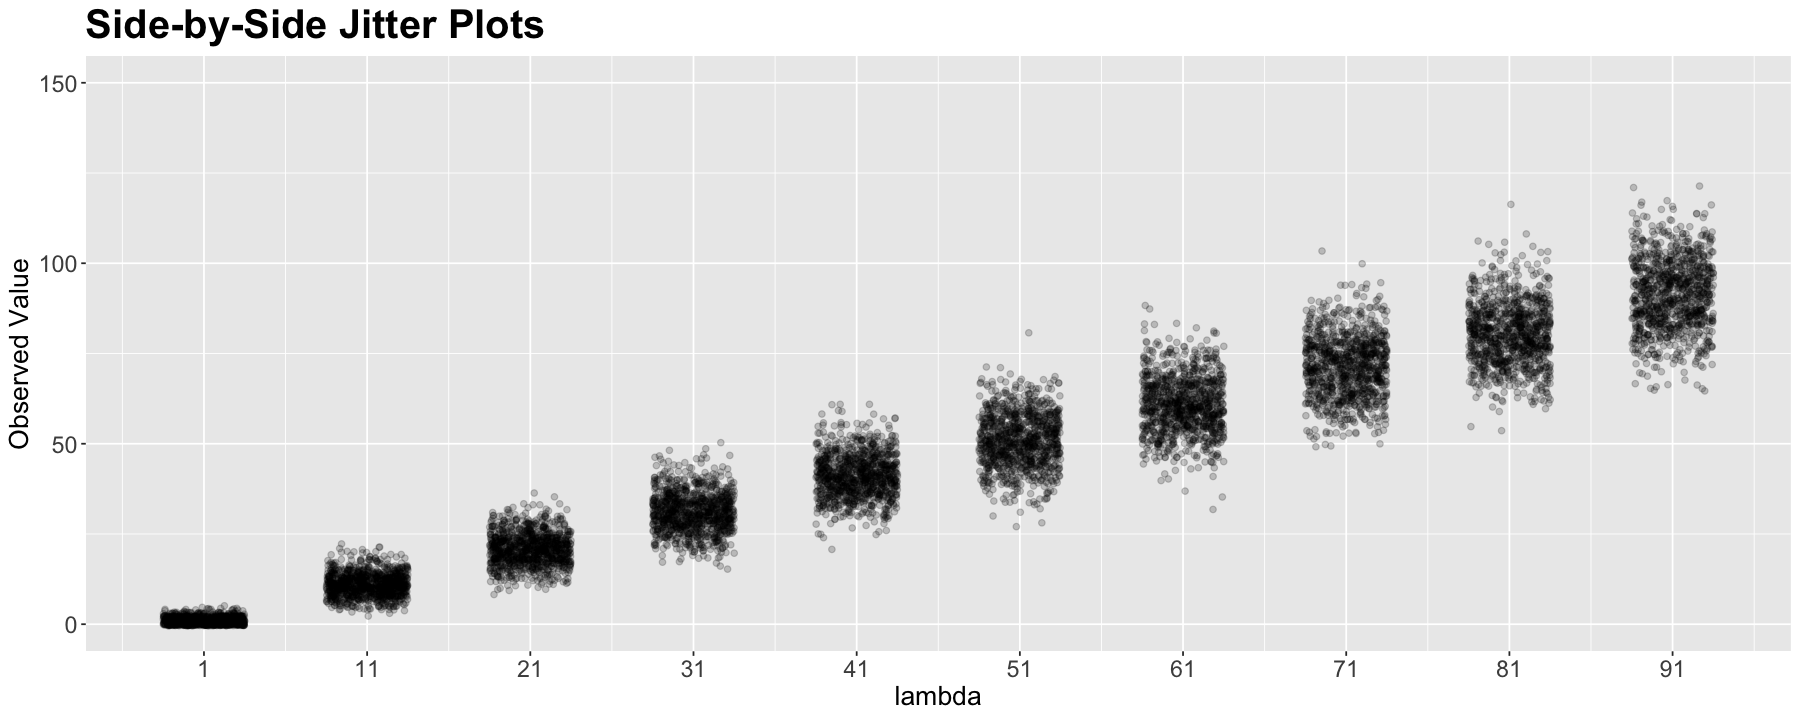

In [40]:
Poisson_samples %>%
  ggplot(aes(lambda, x)) +
  geom_jitter(alpha = .2, width = 2.5) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 16)
  ) +
  coord_cartesian(ylim = c(0, 150)) +
  labs(y = "Observed Value") +
  ggtitle("Side-by-Side Jitter Plots") +
  scale_x_continuous(breaks = seq(1, 91, 10))

The side-by-side jitter plots above illustrate the impact of an increasing variance in each of the ten Poisson populations, where each set of $n = 1000$ data points gets more and more spread out. We see the same trend with the side-by-side boxplots.

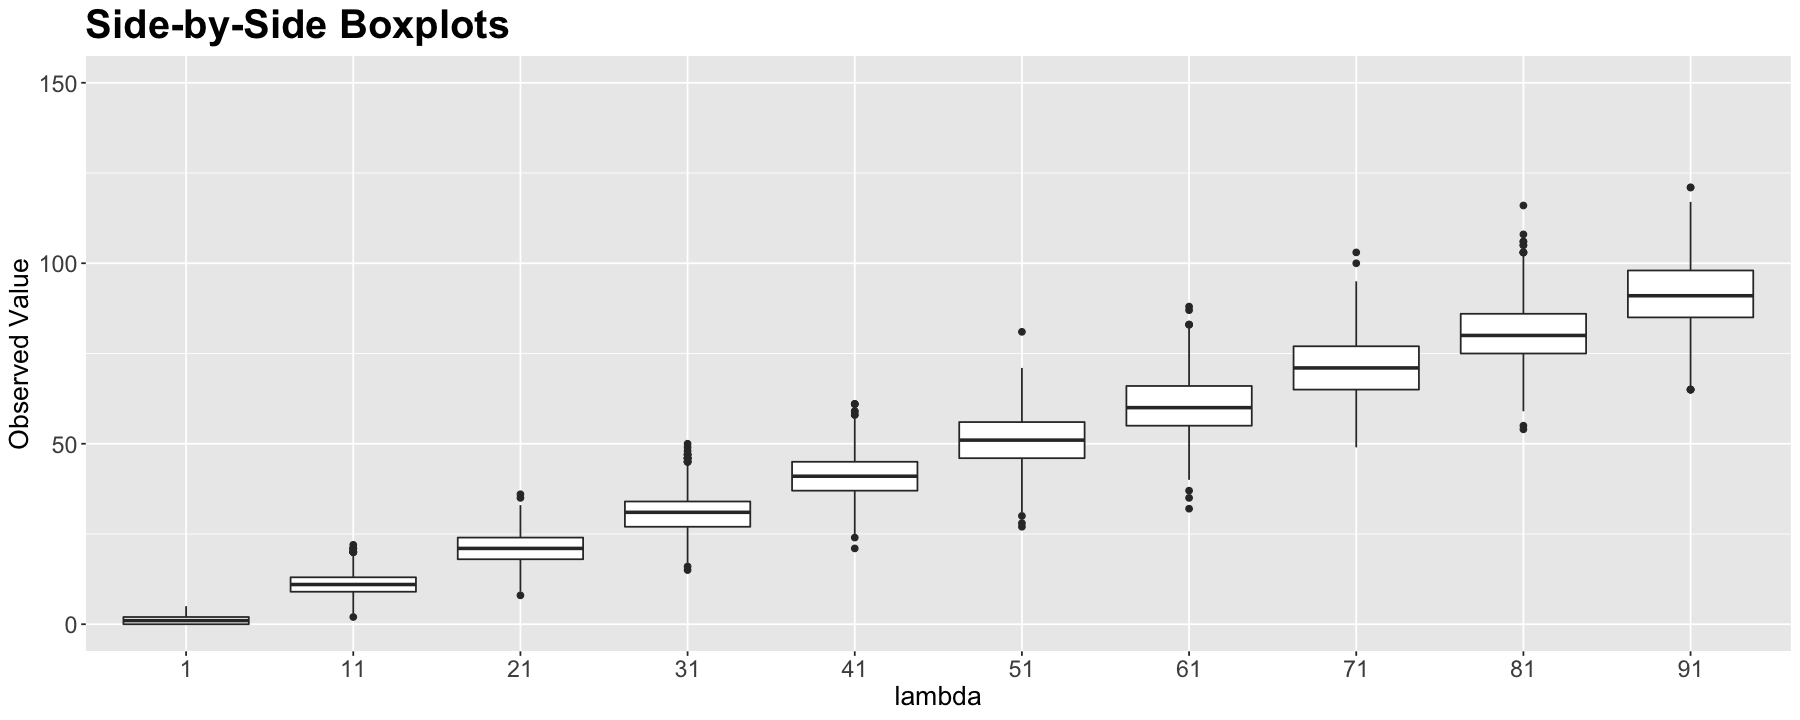

In [41]:
Poisson_samples %>%
  ggplot(aes(x = as_factor(lambda), y = x)) + 
  geom_boxplot() +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 16)
  ) +
  coord_cartesian(ylim = c(0, 150)) +
  labs(y = "Observed Value", x = "lambda") +
  ggtitle("Side-by-Side Boxplots")

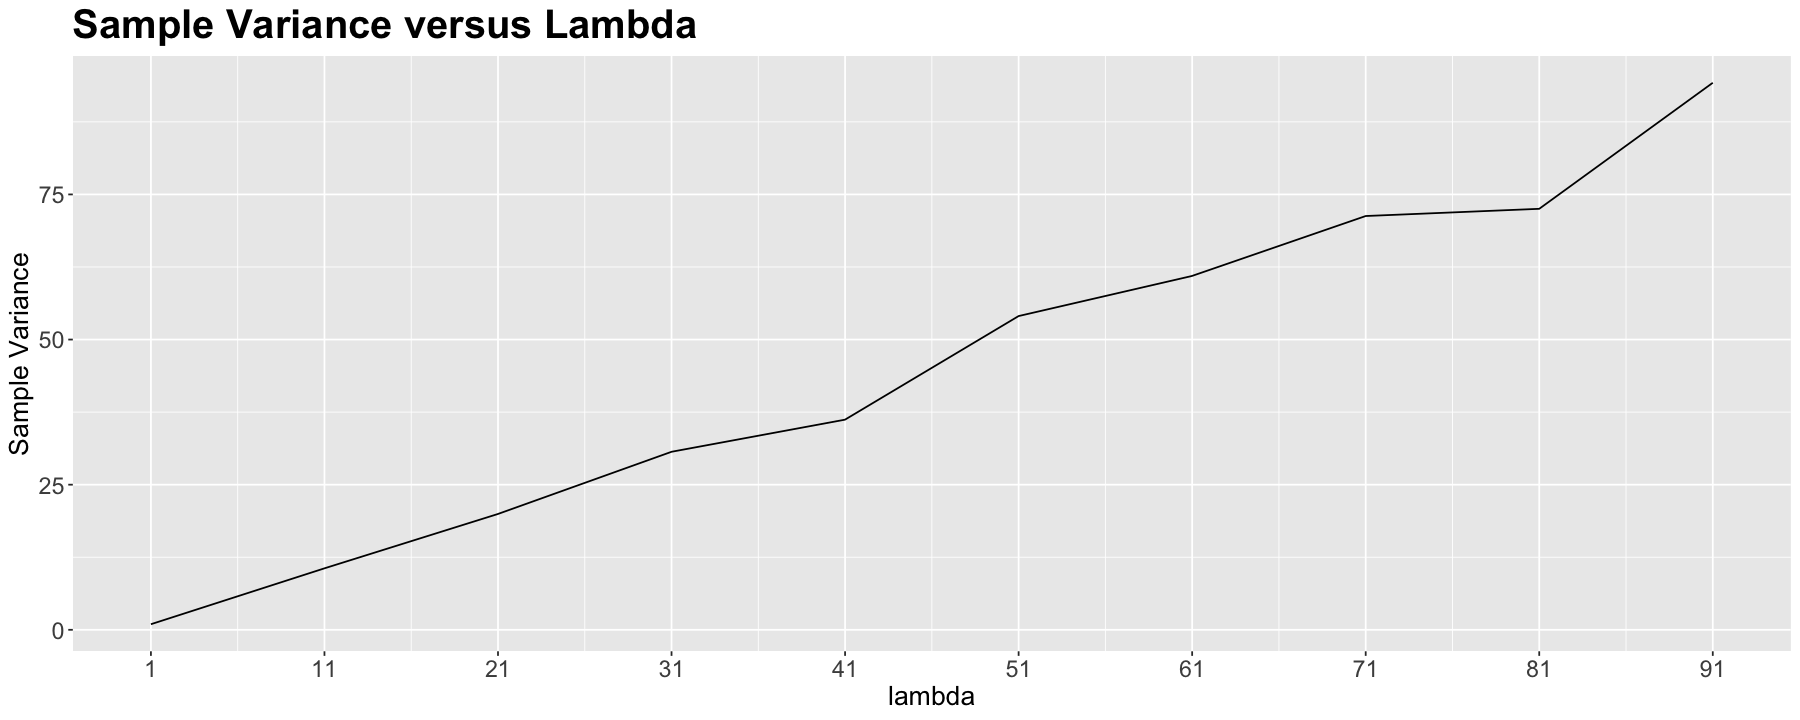

In [42]:
suppressWarnings(suppressMessages(print(Poisson_samples %>% group_by(lambda) %>%
  summarise(sample_variance = var(x)) %>%
  ggplot() +
  geom_line(aes(lambda, sample_variance)) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 16)
  ) +
  labs(y = "Sample Variance", x = "lambda") +
  ggtitle("Sample Variance versus Lambda") +
  scale_x_continuous(breaks = seq(1, 91, 10)))))

Note that the relationship of the sample variance in these samples is practically linear to the population $\lambda$. This is how equidispersion graphically looks like.

Nonetheless, the variance of our data is sometimes larger than the variance considered by our model. 

> **Heads-up:** When the variance is larger than the mean in a random variable, we have **overdispersion**.

This matter will have an impact on the standard error of our parameter estimates, as we will see.

Let us go back to our `poisson_model` with the log link function from the `crabs` dataset with `width` as a regressor:

$$
h(\lambda_i) = \log(\lambda_i) = \beta_0 + \beta X_{\texttt{width}_i}.
$$

In [43]:
summary(poisson_model)


Call:
glm(formula = n_males ~ width, family = poisson, data = crabs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8526  -1.9884  -0.4933   1.0970   4.9221  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.30476    0.54224  -6.095  1.1e-09 ***
width        0.16405    0.01997   8.216  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 632.79  on 172  degrees of freedom
Residual deviance: 567.88  on 171  degrees of freedom
AIC: 927.18

Number of Fisher Scoring iterations: 6


We will test if there is overdispersion in this Poisson regression model. The function `dispersiontest()`, from the package `AER`, tests overdispersion.

Let $Y_i$ be the $i$th Poisson response in the count regression model. *Ideally in the presence of equidispersion*, $Y_i$ has the following parameters:

```{math}
\begin{gather*}
\mathbb{E}(Y_i) = \lambda_i \\
\text{Var}(Y_i) = \lambda_i.
\end{gather*}
```

The test uses the following mathematical expression:

$$
\text{Var}(Y_i) = \overbrace{(1 + \gamma)}^\text{Dispersion Factor} \lambda_i,
$$

with the hypotheses

$$H_0: 1 + \gamma = 1$$
$$H_a: 1 + \gamma > 1.$$

When there is evidence of overdispersion in our data, *we will reject $H_0$*.

In [44]:
dispersiontest(poisson_model)


	Overdispersion test

data:  poisson_model
z = 5.558, p-value = 1.364e-08
alternative hypothesis: true dispersion is greater than 1
sample estimates:
dispersion 
  3.157244 


With $\alpha = 0.05$, we reject $H_0$ since the $p\text{-value} < .001$. Hence, the `poisson_model` has overdispersion.

One of the consequences of having overdispersion in our model is that our standard errors will be distorted, which will impact if we want to use the model to make inference.

Alternatively to a Poisson regression model, we can use quasi-Poisson:

- The quasi-Poisson family allows the regular variance value to be multiplied by an overdisperdion factor $\theta$ as follows:

$$
\text{Var}(Y_i) = \theta \lambda_i
$$

- Also, note that using the quasi-Poisson does not change the estimates, just the standard errors.
- Finally, we cannot get the AIC or BIC using a quasi-Poisson, because there is no likelihood function for this method.

Unlike the Poisson regression models, quasi-Poisson is not a maximum likelihood approach but quasi-likelihood. Roughly speaking, this approach computes differently each standard error $\mbox{se}(\hat{\beta}_j)$ (used for testing the significance of a regression coefficient $\beta_j$ associated to the $j$th regressor). This computation considers the fact that there is overdispersion in the data, but how is it possible? The answer lies in an overdispersion parameter $\theta$ that represents this extra variance in our data. Hence, $\theta$ quantifies as a scale factor how much variance is larger than the mean and lets the model provide a better fitting.

To fit this model, we use the function `glm()` and its argument `family = quasipoisson` (required to specify the quasi-Poisson model).

In [45]:
quasi_poisson_model <- glm(n_males ~ width, family = quasipoisson, data = crabs)
summary(quasi_poisson_model)


Call:
glm(formula = n_males ~ width, family = quasipoisson, data = crabs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8526  -1.9884  -0.4933   1.0970   4.9221  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.30476    0.96729  -3.417 0.000793 ***
width        0.16405    0.03562   4.606 7.99e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasipoisson family taken to be 3.182205)

    Null deviance: 632.79  on 172  degrees of freedom
Residual deviance: 567.88  on 171  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 6


We can see that the dispersion parameter is `3.18`.

Lastly, we can also use the negative binomial regression: 

  - The negative binomial regression has $\text{Var}(Y_i) = \lambda_i + \theta \lambda_i^2$, for a constant $\theta$.
  - Therefore, the model has more flexibility to deal with overdispersion.
  
To fit a negative binomial regression, we can use the function `glm.nb()` from package `MASS`.

In [46]:
negative_binomial_model <- glm.nb(n_males ~ width, data = crabs)
summary(negative_binomial_model)


Call:
glm.nb(formula = n_males ~ width, data = crabs, init.theta = 0.90456808, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7798  -1.4110  -0.2502   0.4770   2.0177  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.05251    1.17143  -3.459 0.000541 ***
width        0.19207    0.04406   4.360  1.3e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.9046) family taken to be 1)

    Null deviance: 213.05  on 172  degrees of freedom
Residual deviance: 195.81  on 171  degrees of freedom
AIC: 757.29

Number of Fisher Scoring iterations: 1


              Theta:  0.905 
          Std. Err.:  0.161 

 2 x log-likelihood:  -751.291 

The negative binomial distribution is a generalization of the Poisson distribution. This regression model is even more flexible than the quasi-Poisson case since the variance's representation allows it to be a quadratic function of the mean with an additional parameter. As in the Poisson regression model, the negative binomial model is a maximum likelihood approach.

As we can see, the previous two count regression models have extra parameters in the variance expression that allows us to construct a more accurate model for specific count data (since the mean and the variance do not need to be equal). Note that the variable association tests and conclusions are conducted similarly under these two models, just as in the Poisson regression.

## 6. Wrapping Up

- GLMs are the way to go in regression analysis when the response is not continuous, and we need to perform inferences.
- The link function is key in this class of models for the response's conditioned expected value: binary and counts.
- Nonetheless, is there any modelling option when the response is categorical (nominal or ordinal)?